In [1]:
library('hdp')
library('clusterCrit')
library('grid')
library('gridExtra')
library('ggplot2')
library('ggrepel')
library('RColorBrewer')
library('dplyr')
library('IRdisplay')
source('../../../src/tools.R')     # custom tools function
source('../../../src/hdp_tools.R') # hdp related functions
source('../../../src/hdp_tools_yanis.R')
theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed

Run citation('hdp') for citation instructions,
    and file.show(system.file('LICENSE', package='hdp')) for license details.

Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [12]:
df_modif_final <- read.table("../../../data/updated_dataset/modif_final.csv",sep = ',' , header = T)
rownames(df_modif_final)<- df_modif_final$X
df_modif_final <- df_modif_final[,-1:-3]

In [13]:
###Binomial
num_cols = ncol(df_modif_final)
bin <- function(x){
    set.seed(123)
  (rbinom(1, num_cols, mean(x))+1)/num_cols
}

###Normal

normal <- function(x){
    set.seed(123)
  abs(rnorm(1,mean(x),sd(x)))
}

###Poisson

poisson <- function(x){
    set.seed(123)
  (rpois(num_cols,1)+1)/num_cols
}

###Uniform equally over all columns

equally <- function(x){
    set.seed(123)
  1/num_cols
}

###Repet 1

repet <- function(x){
    set.seed(123)
  1
}

#sapply(df_gene,equally)
binomial <- unlist(sapply(df_modif_final,bin))
gaussian <- unlist(sapply(df_modif_final,normal))
pois <- as.numeric(unlist(sapply(df_modif_final,poisson)))
unif <- unlist(sapply(df_modif_final,equally))
repetition <- unlist(sapply(df_modif_final,repet))
lists<- list(binomial,gaussian,unif,repetition)
for (lis in lists) {
    initialise_hdp_yanis(data=df_modif_final,alphaa=1,alphab=1,hh=lis)
}

Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!
Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!


##### 3 17 7000 350  very good
3 17 5000 350,450 found the component 10   with alpha =0.5 and 2

In [20]:
hdp <- initialise_hdp_yanis(df_modif_final,hh=gaussian,alphaa = 2,alphab= 0.5)

Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!


In [21]:
number_of_chains <- 3
chain_list <- vector('list', number_of_chains)

for (i in 1:number_of_chains) {
    seed <- i * 100
    print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))
    
    # run single hdp chain
    chain_list[[i]] <- activate_and_run_hdp(hdp,
                                            initcc = 13,
                                            burnin = 7000,
                                            n      = 350,
                                            space  = 20,
                                            seed   = seed)
    print_and_flush('\n')
}

multi_output <- hdp_multi_chain(chain_list)
multi_output

### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"



Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 1050 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of data items per DP: 0 2 2 6 3 6 2 4 3 2 ...
 Index of conparam per DP: 1 1 1 1 1 1 1 1 1 1 ...
 Conparam hyperparameters and current value:
           Shape Rate     Value
Conparam 1     2  0.5 0.4722822
 Number of data categories: 103 
 Number of clusters: 14 
 Initialised with 13 clusters, using random seed 100 

Extract HDP components from posterior sampling
  → extract components... done!
* 10 components found


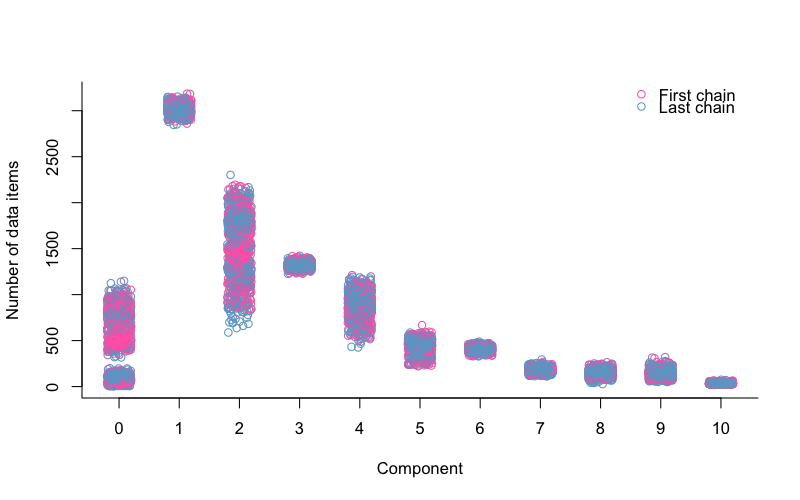

In [22]:
multi_output_cluster_10 <- extract_components(multi_output)
plot_components_size(multi_output_cluster_10)

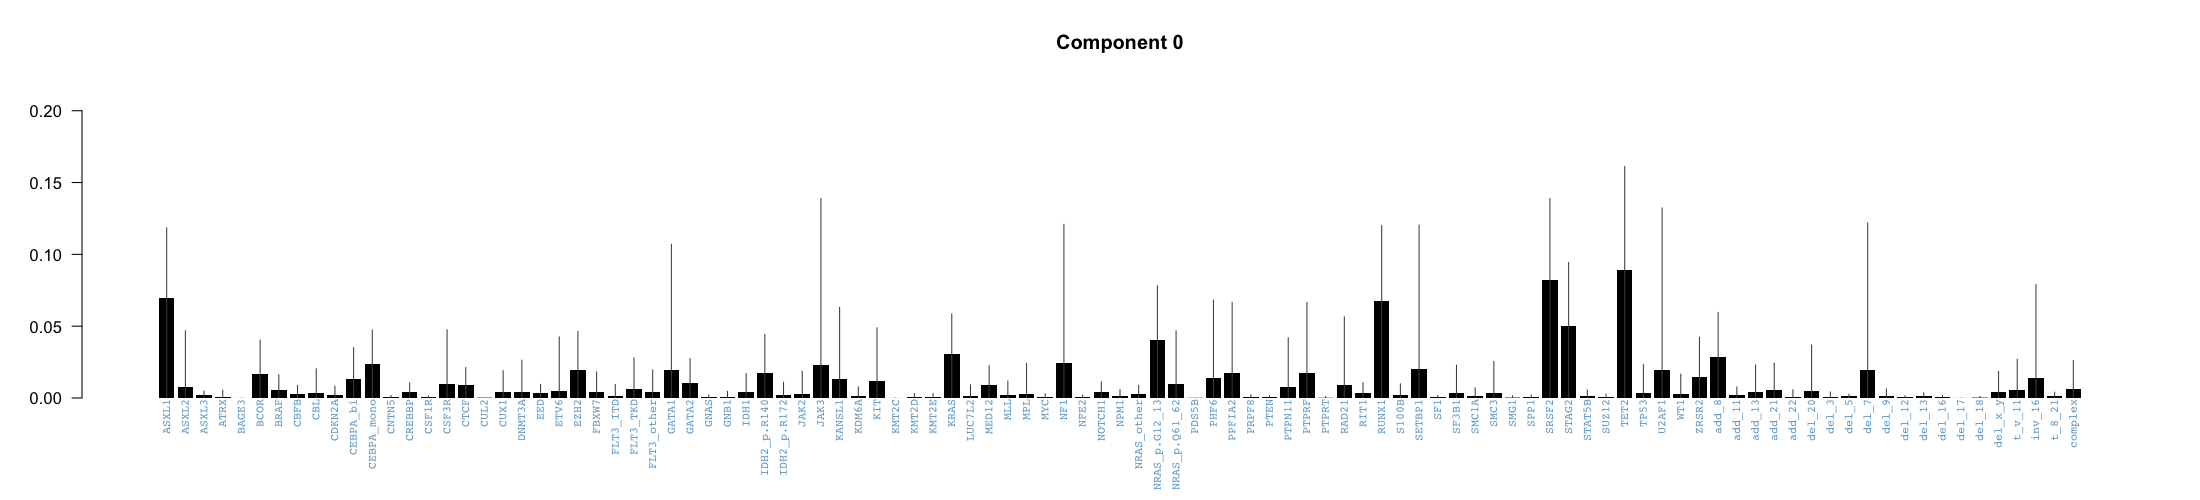

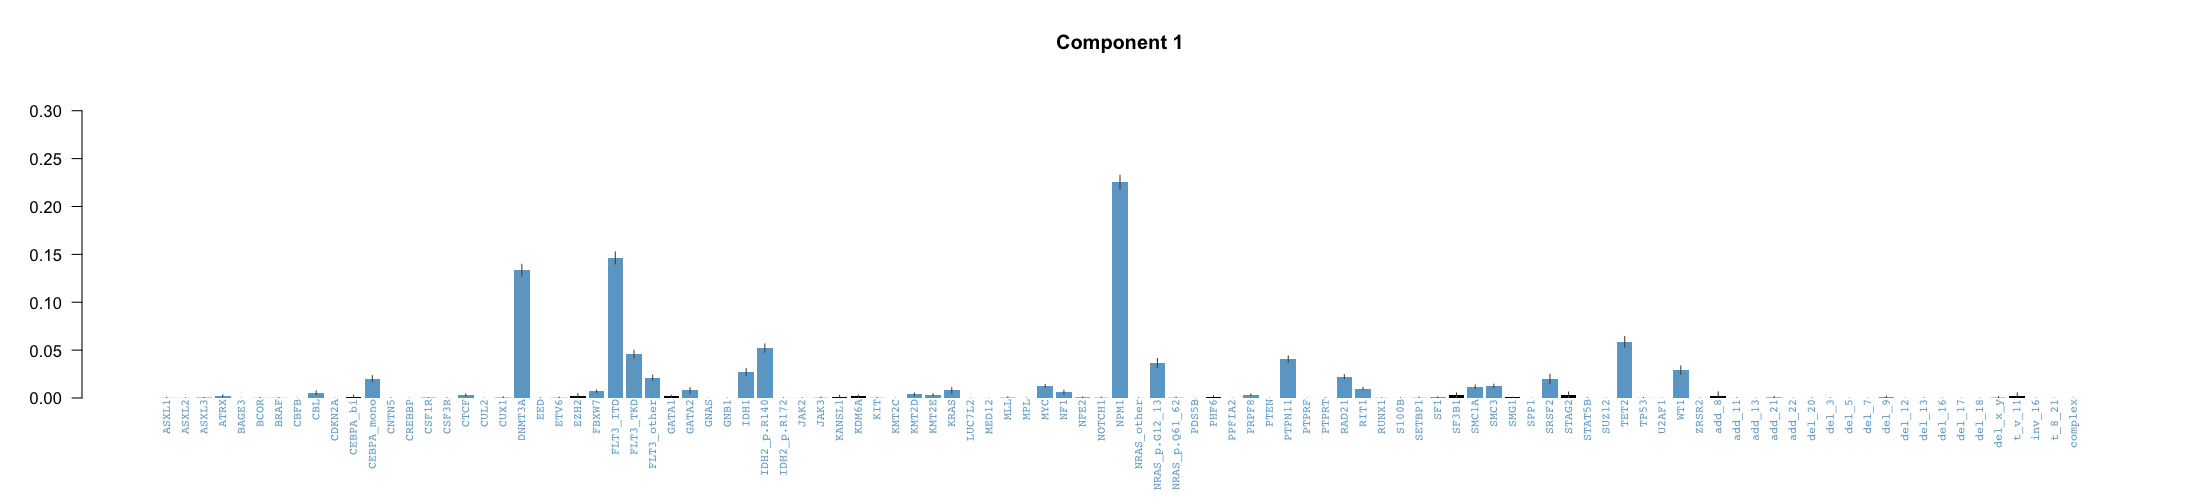

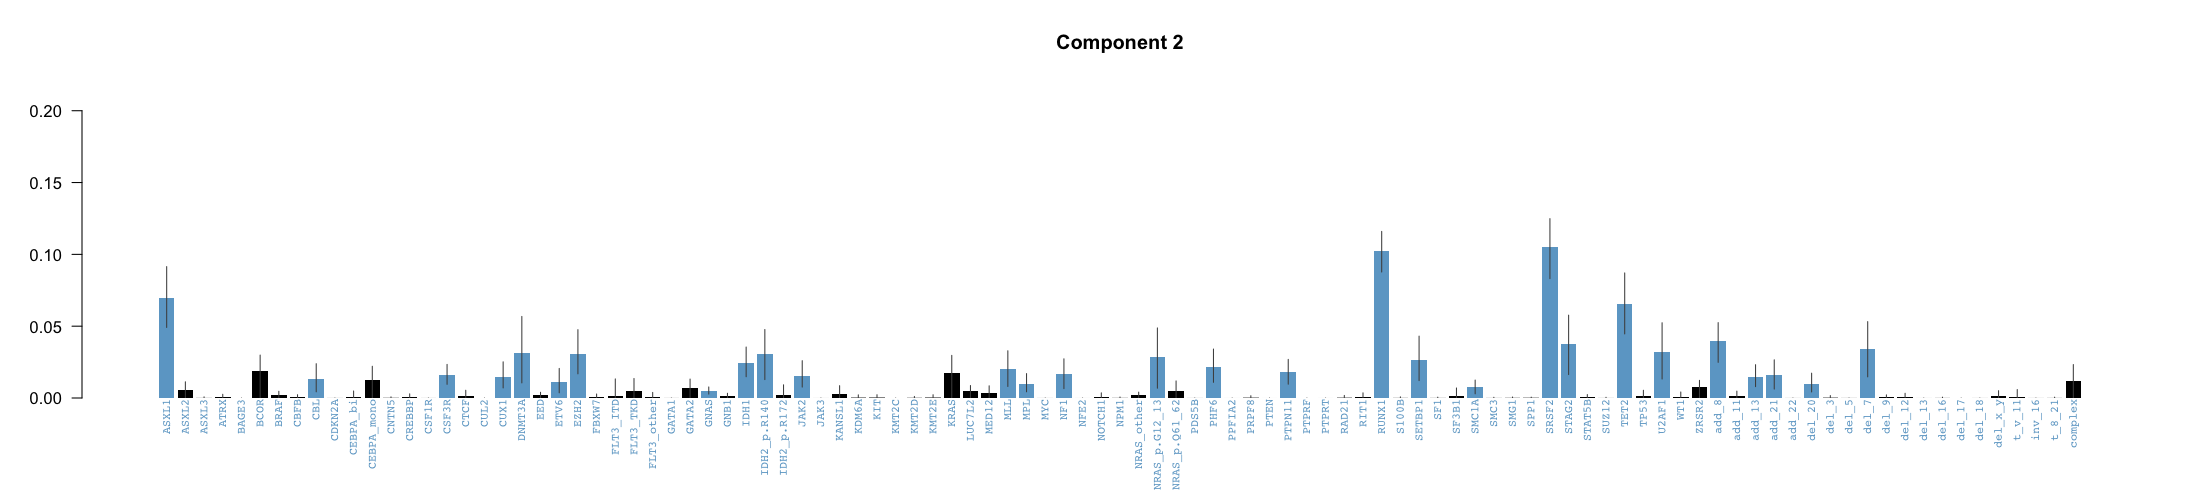

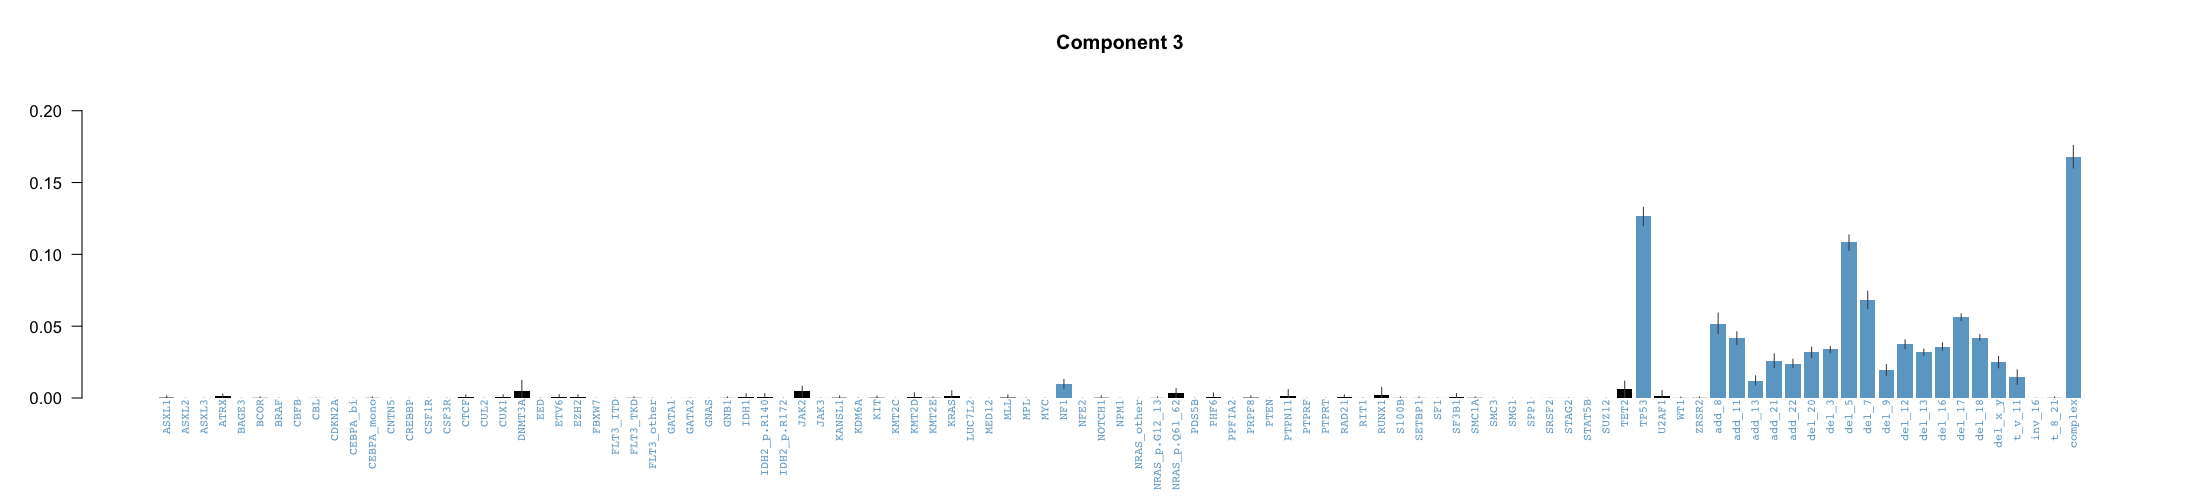

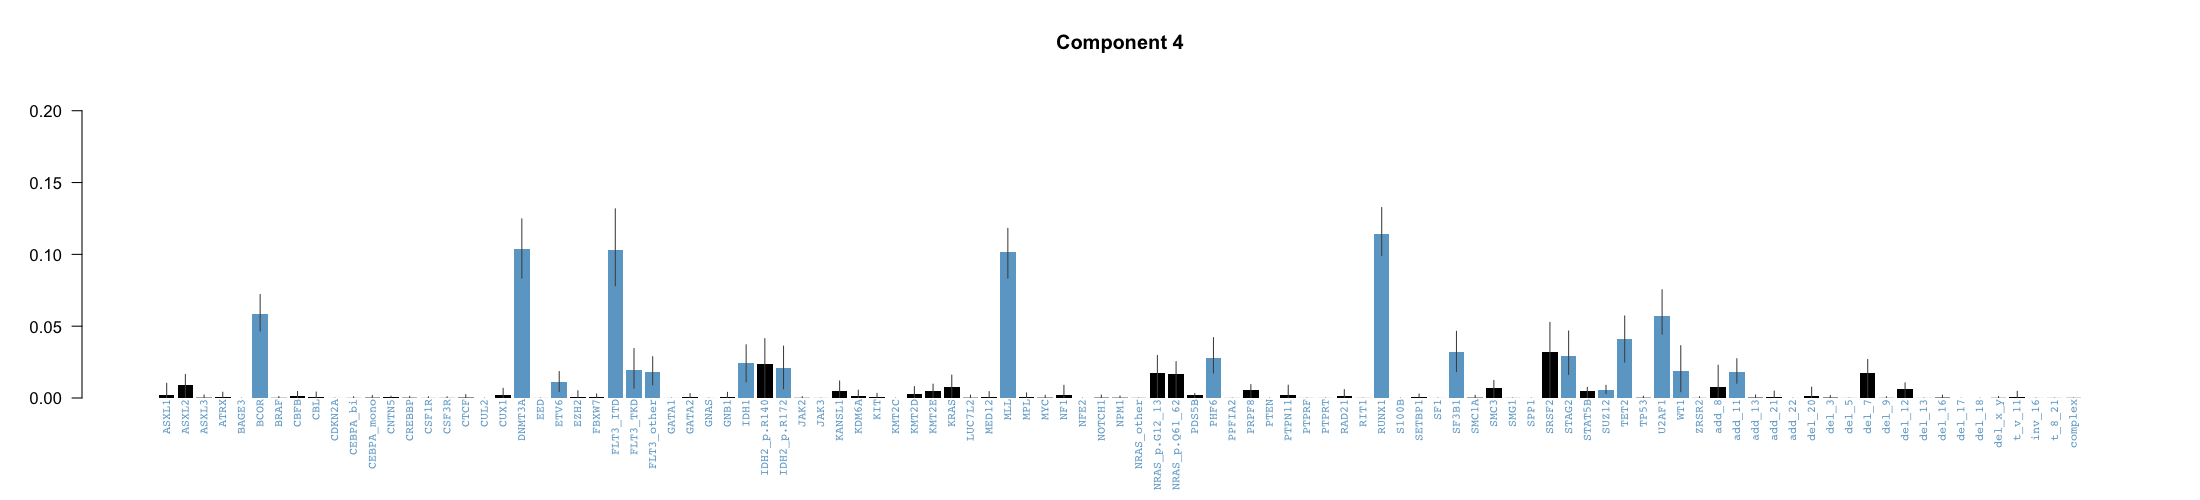

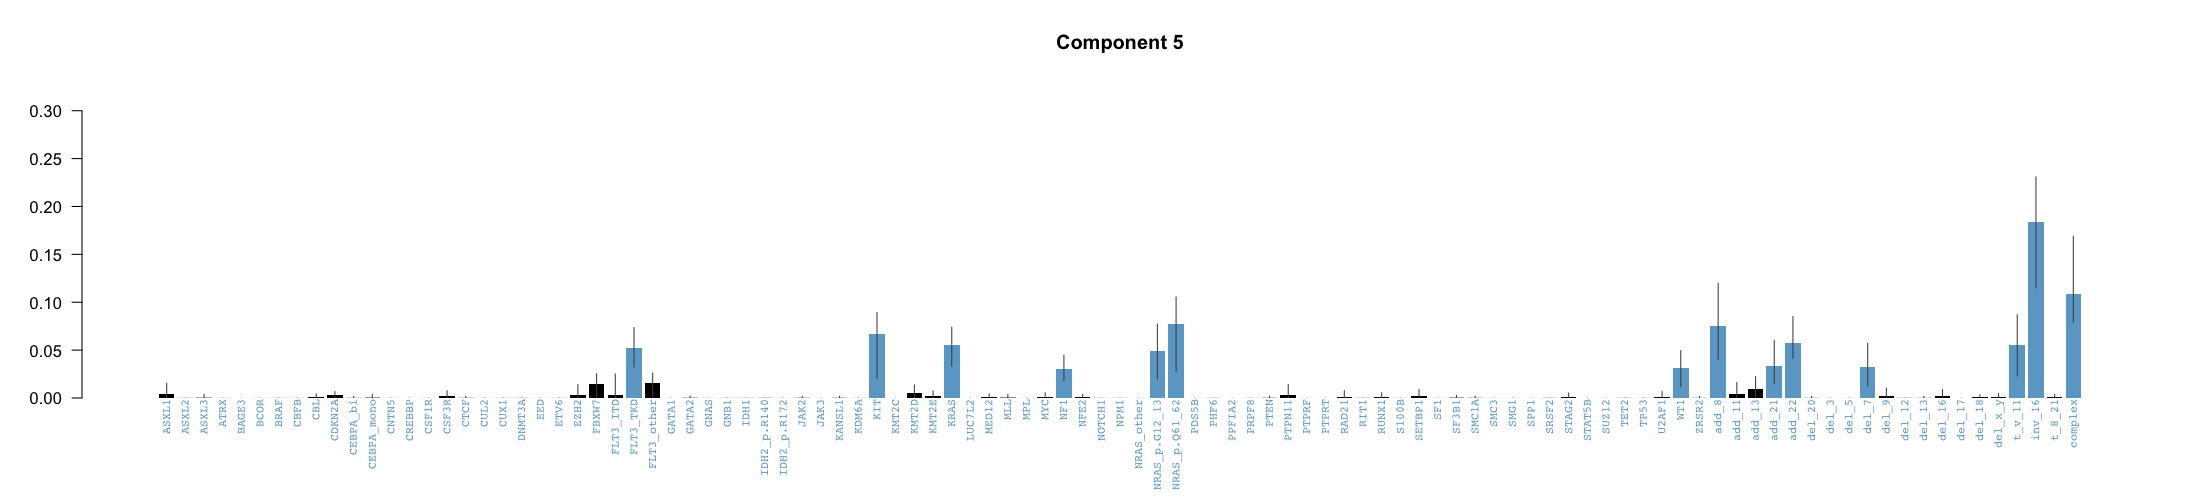

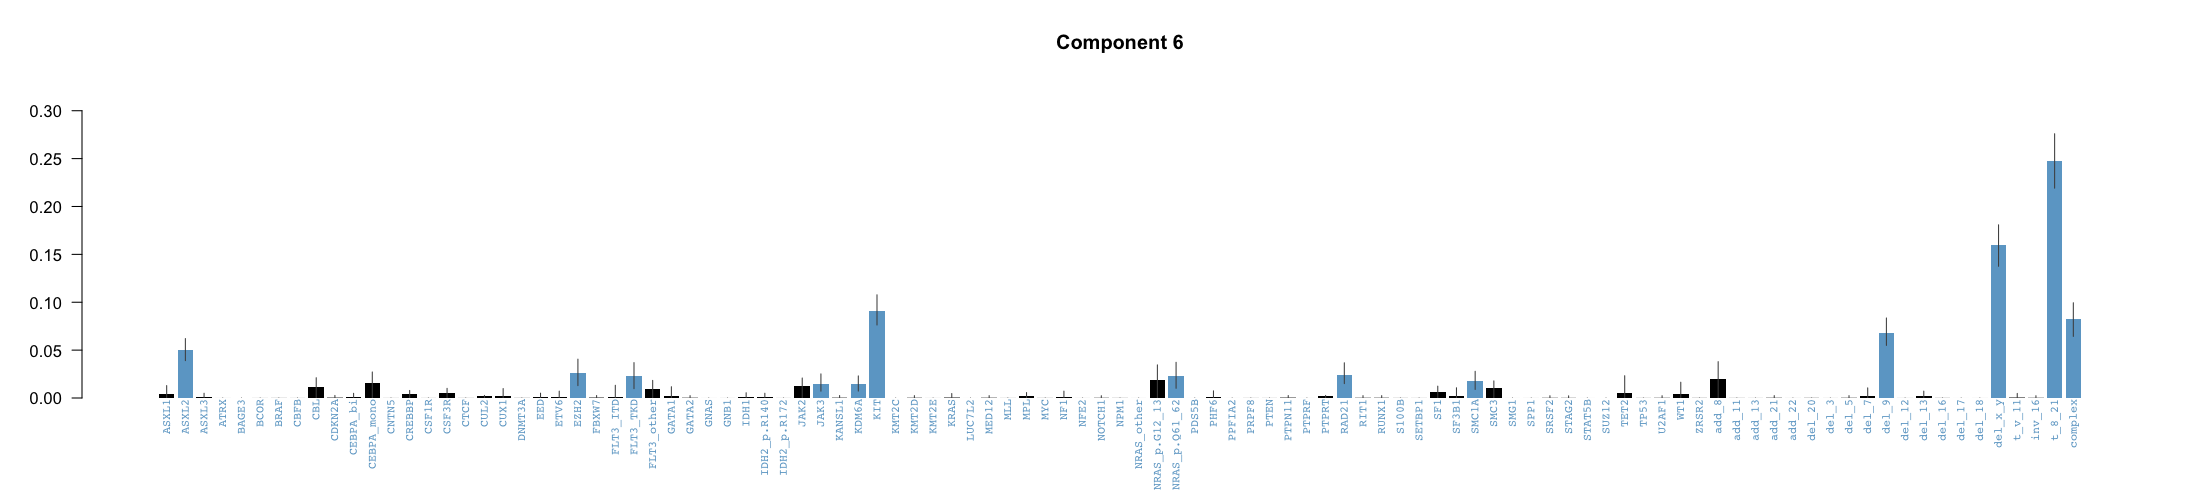

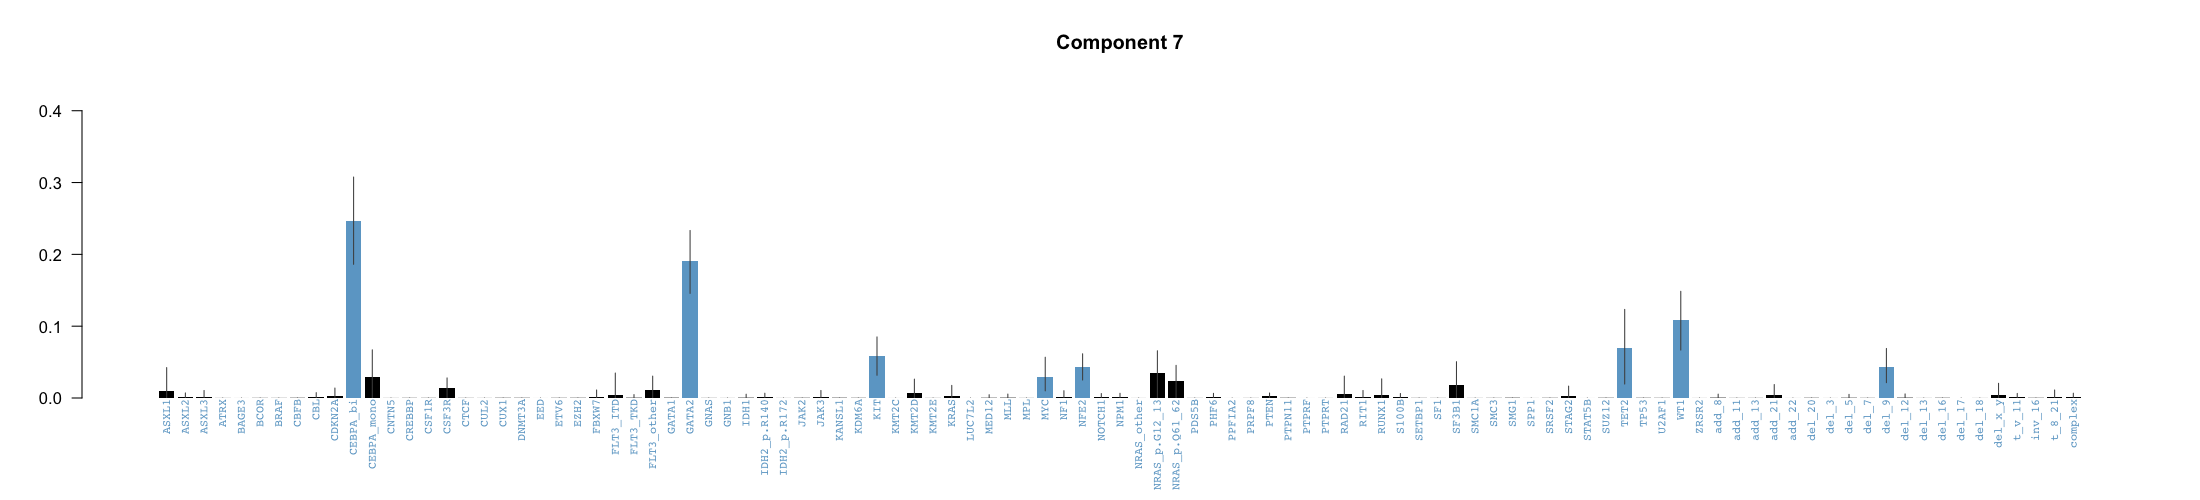

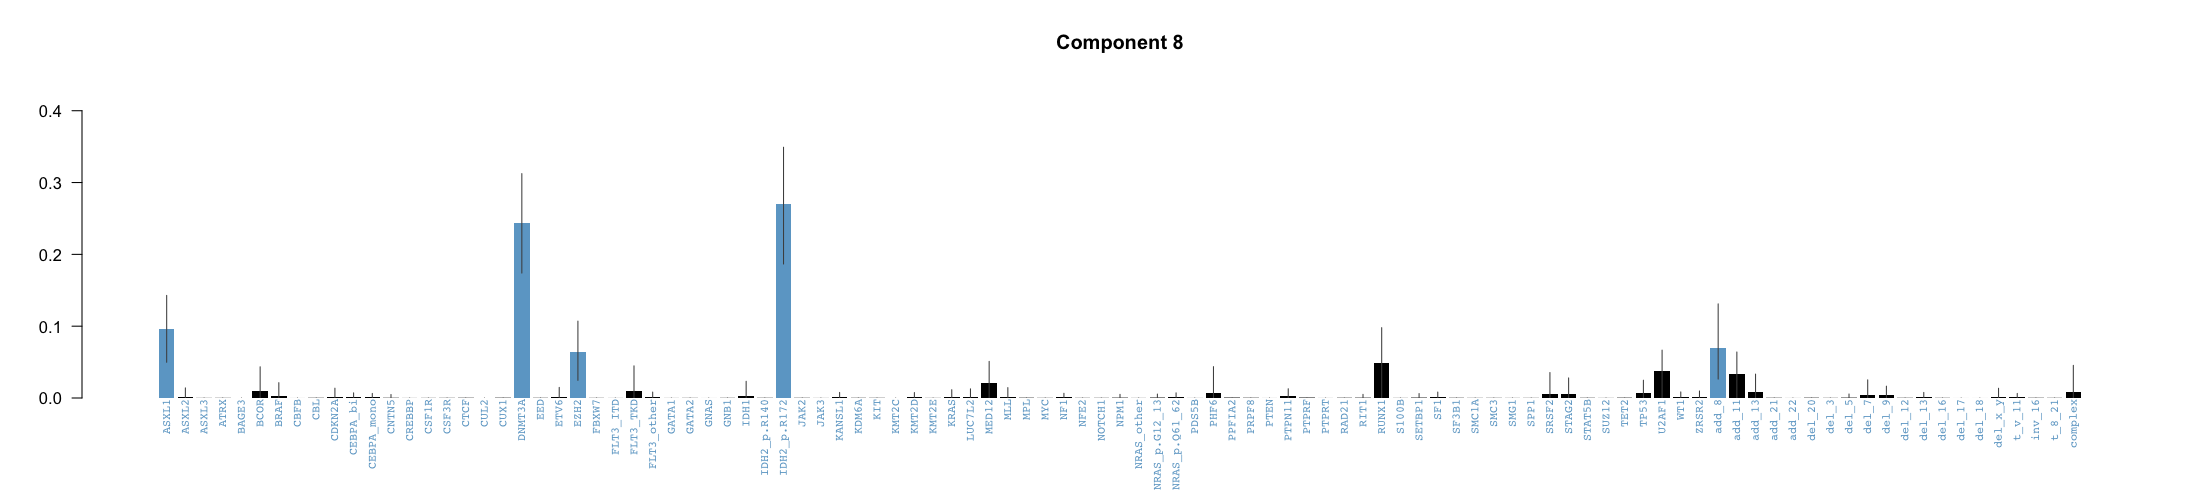

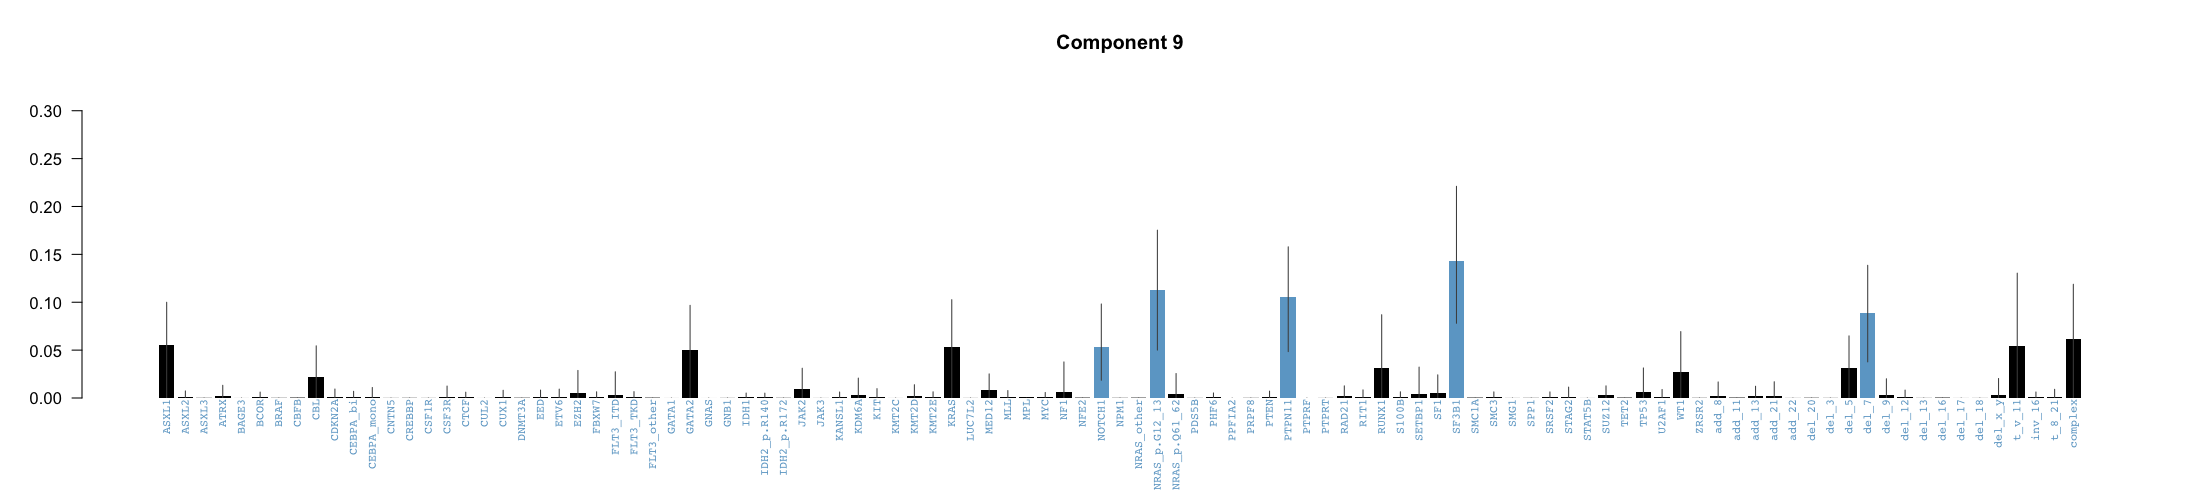

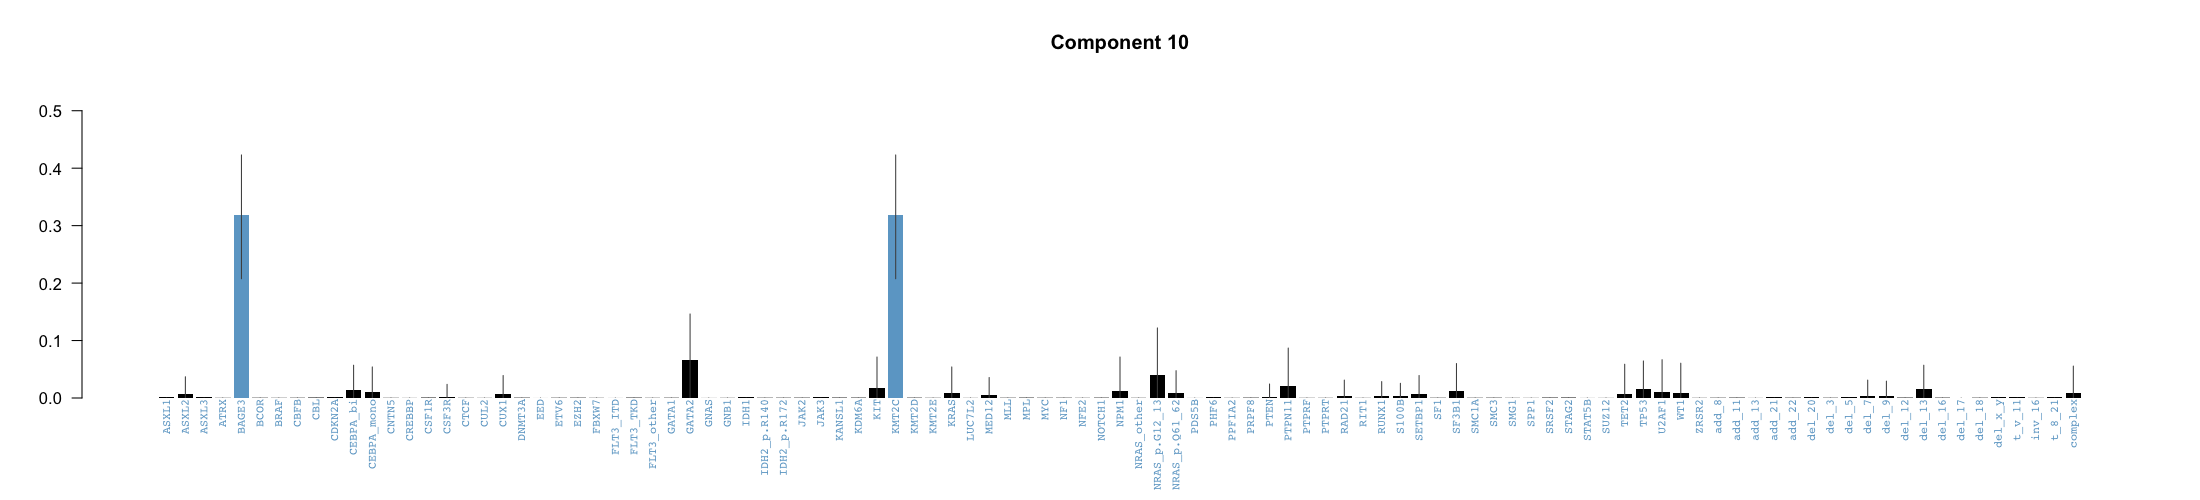

In [23]:
plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))

In [24]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])

Number of components: 10
Number of NA rows   : 65


values      count freq             
2  1            858  39.906976744186  
3  2            380  17.6744186046512 
4  3            222  10.3255813953488 
5  4            200  9.30232558139535 
6  5            142  6.6046511627907  
7  6            114  5.30232558139535 
12 NaN           65  3.02325581395349 
1  0             48  2.23255813953488 
8  7             47  2.18604651162791 
9  8             35  1.62790697674419 
10 9             30  1.3953488372093  
11 10             9  0.418604651162791
13 -- total -- 2150  100%

In [ ]:
#3 13 4000 7000 0.5 2

In [14]:
hdp <- initialise_hdp_yanis(df_modif_final,hh=gaussian,alphaa = 0.5,alphab= 2)

Initialise HDP on a 2150 x 103 dataframe
  → create HDP structure... done!
  → add DP node for each patient... done!
  → assign the data to the nodes... done!


In [15]:
number_of_chains <- 3
chain_list <- vector('list', number_of_chains)

for (i in 1:number_of_chains) {
    seed <- i * 100
    print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))
    
    # run single hdp chain
    chain_list[[i]] <- activate_and_run_hdp(hdp,
                                            initcc = 13,
                                            burnin = 7000,
                                            n      = 400,
                                            space  = 20,
                                            seed   = seed)
    print_and_flush('\n')
}

multi_output <- hdp_multi_chain(chain_list)
multi_output

### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"



Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 1200 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of data items per DP: 0 2 2 6 3 6 2 4 3 2 ...
 Index of conparam per DP: 1 1 1 1 1 1 1 1 1 1 ...
 Conparam hyperparameters and current value:
           Shape Rate     Value
Conparam 1   0.5    2 0.4187463
 Number of data categories: 103 
 Number of clusters: 10 
 Initialised with 13 clusters, using random seed 100 

Extract HDP components from posterior sampling
  → extract components... done!
* 7 components found


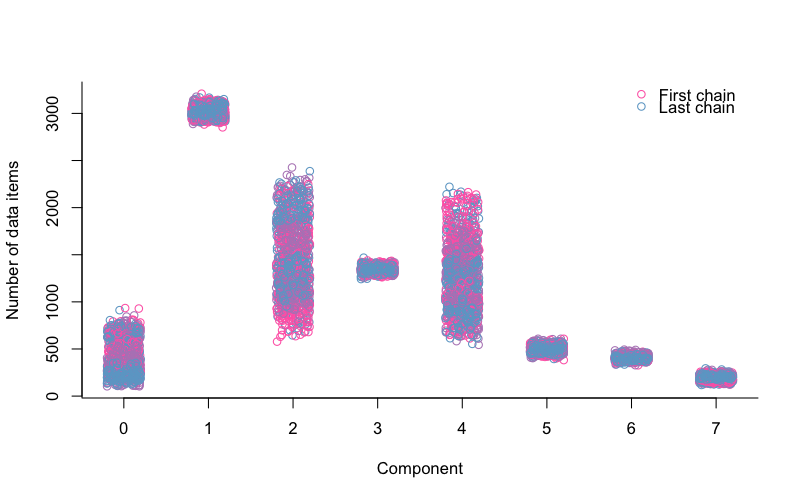

In [19]:
multi_output_cluster_10 <- extract_components(multi_output)
plot_components_size(multi_output_cluster_10)

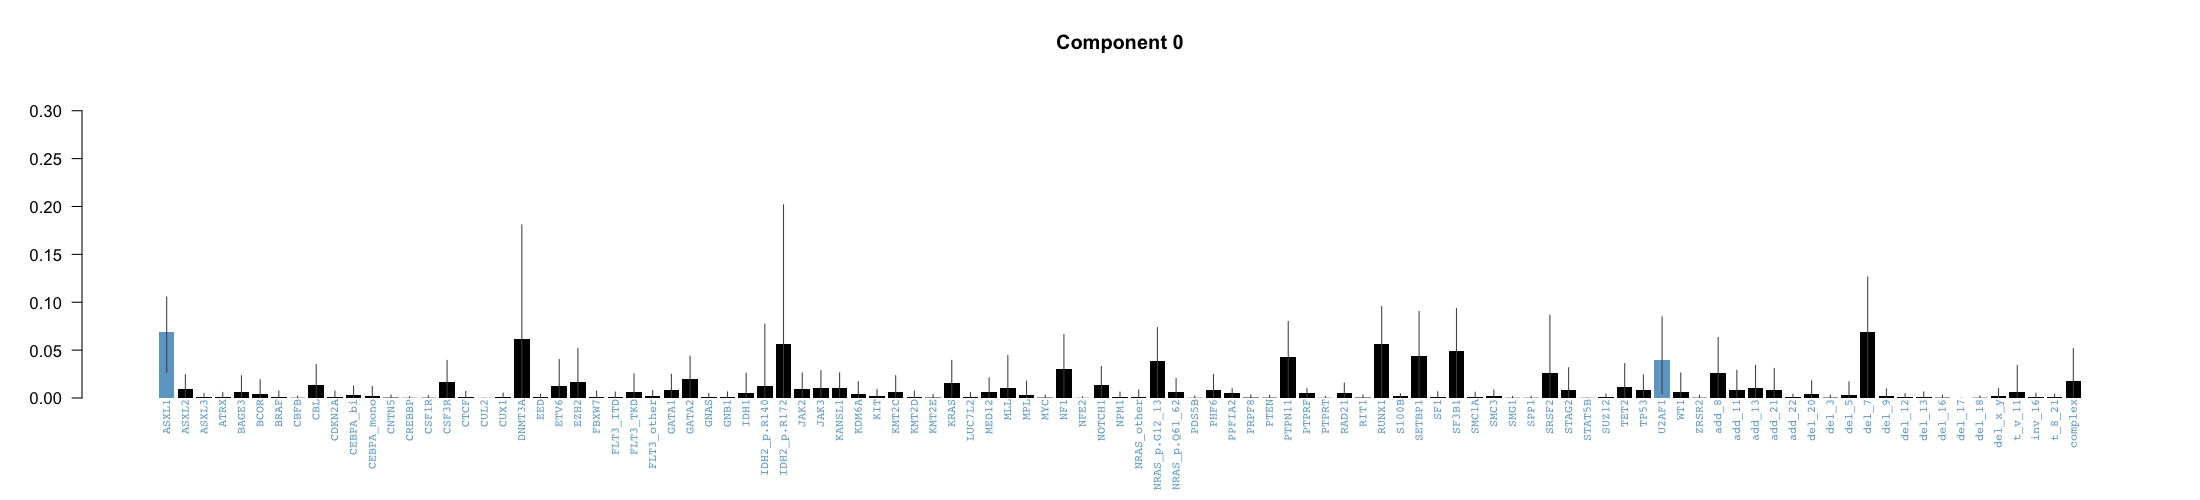

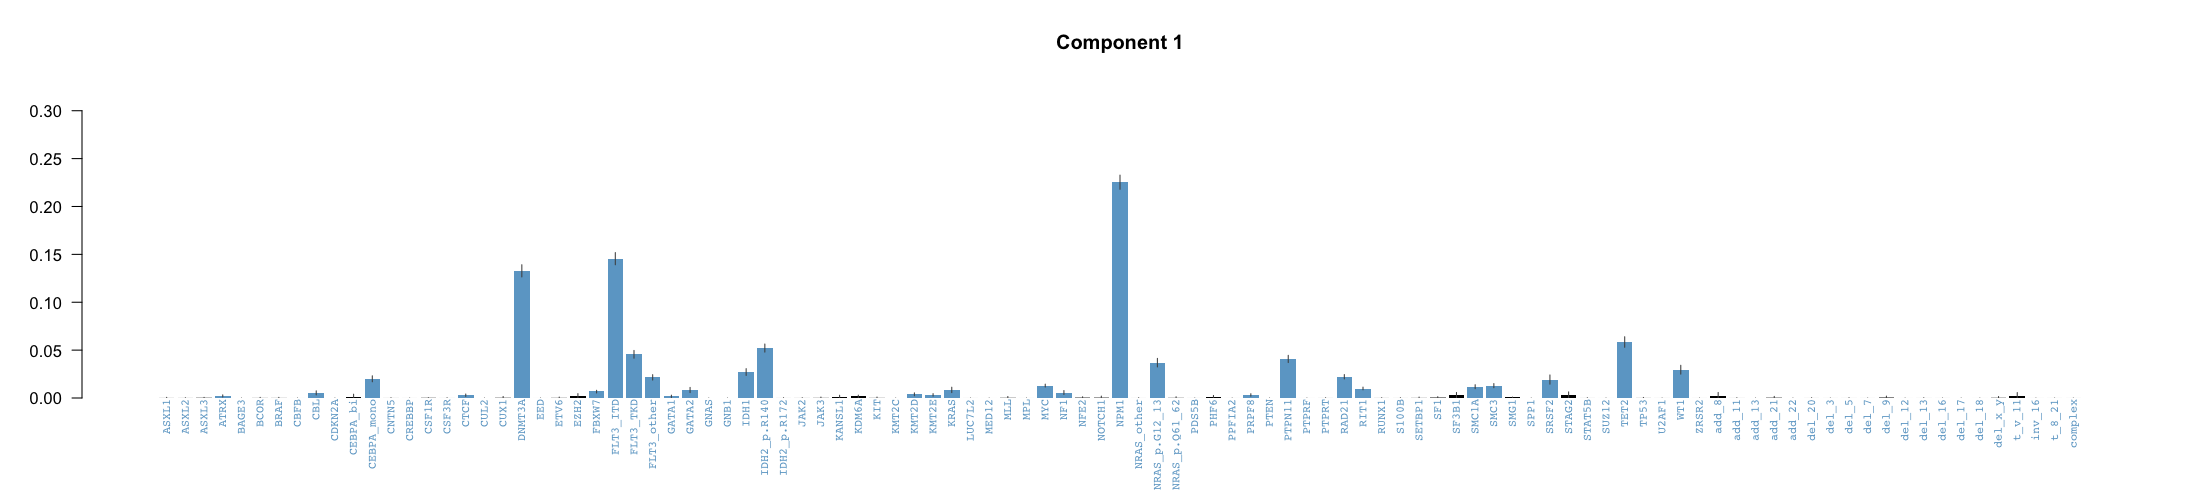

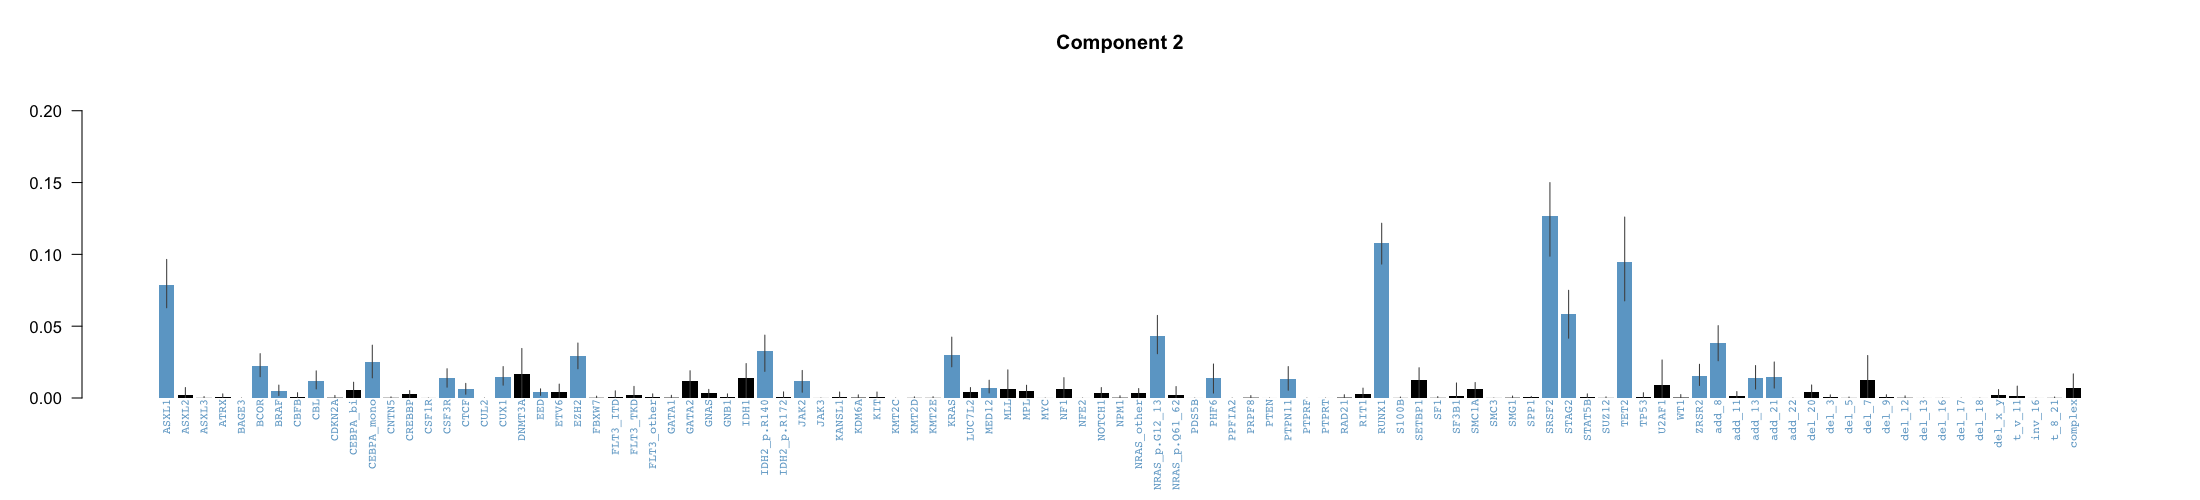

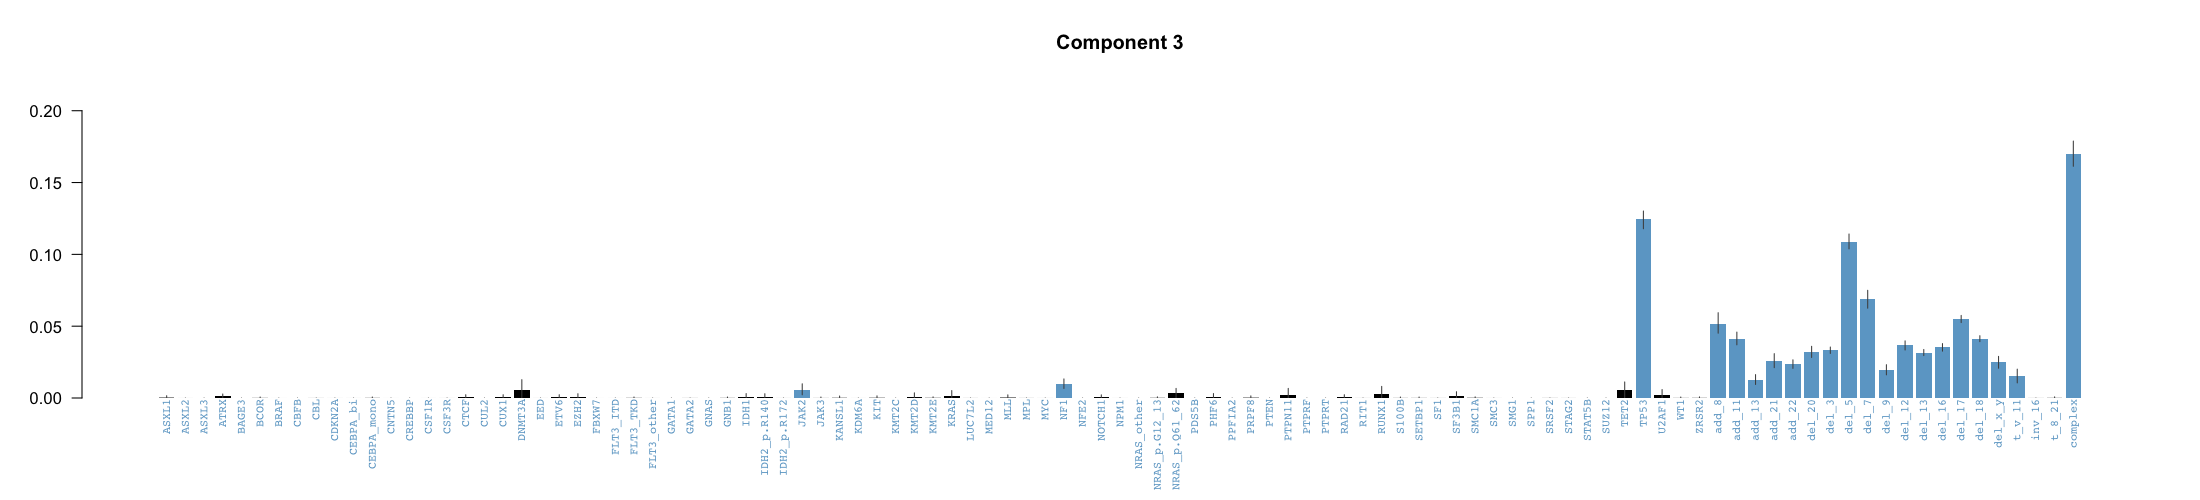

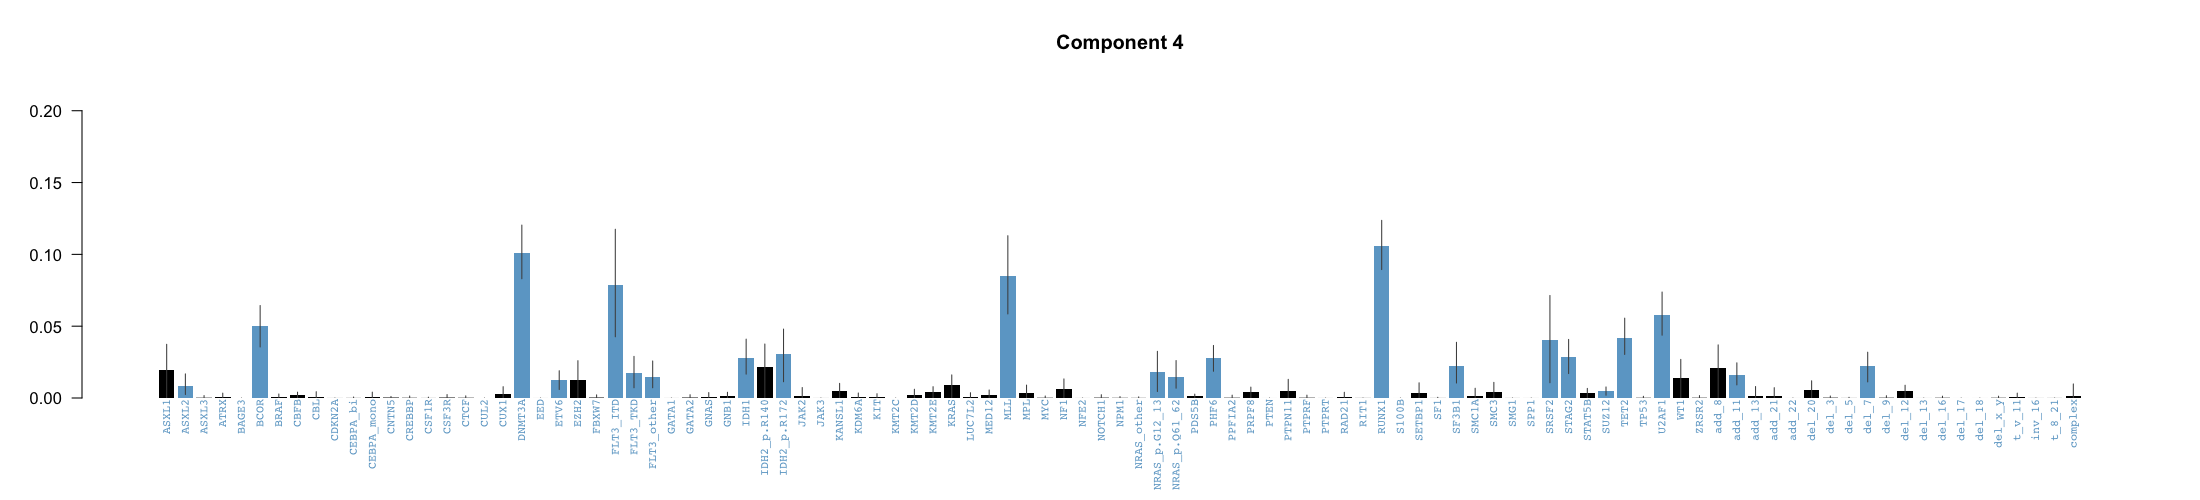

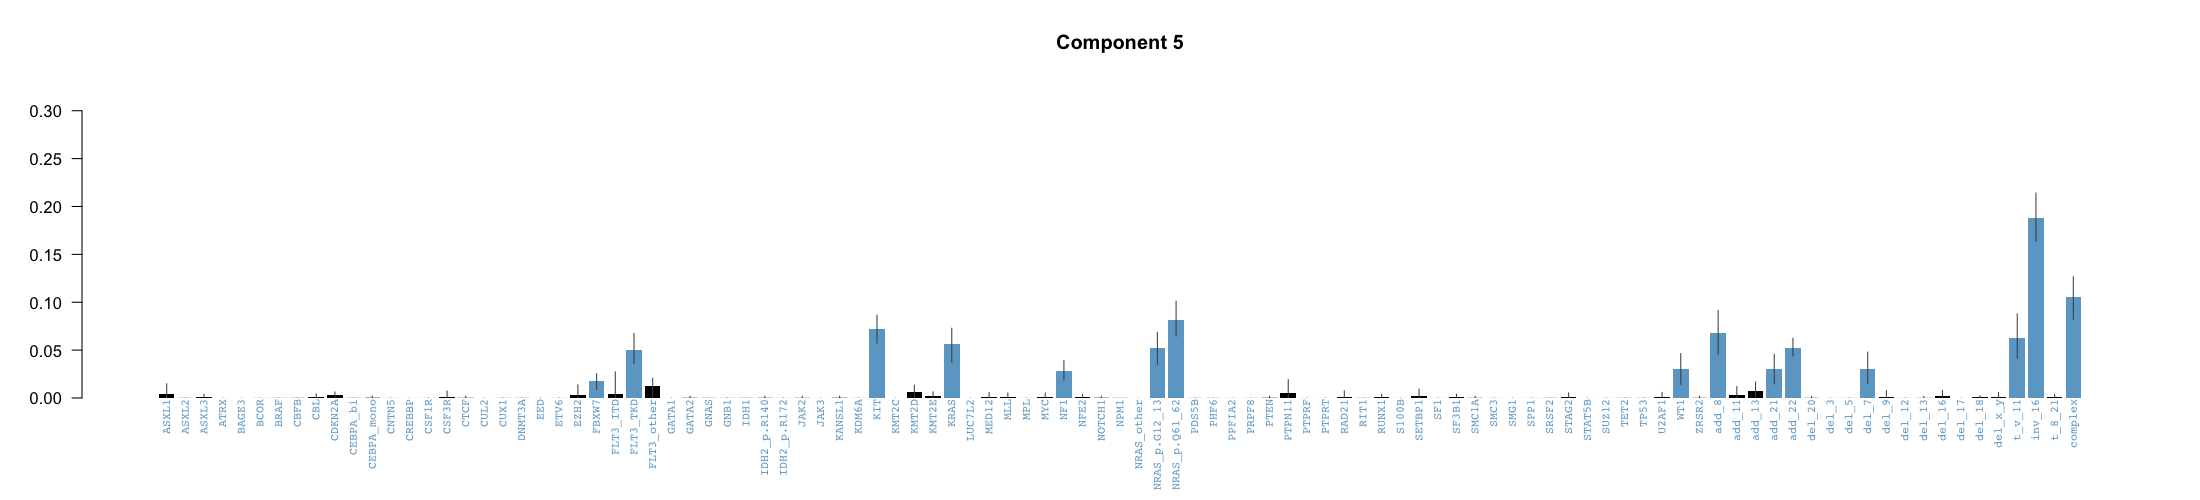

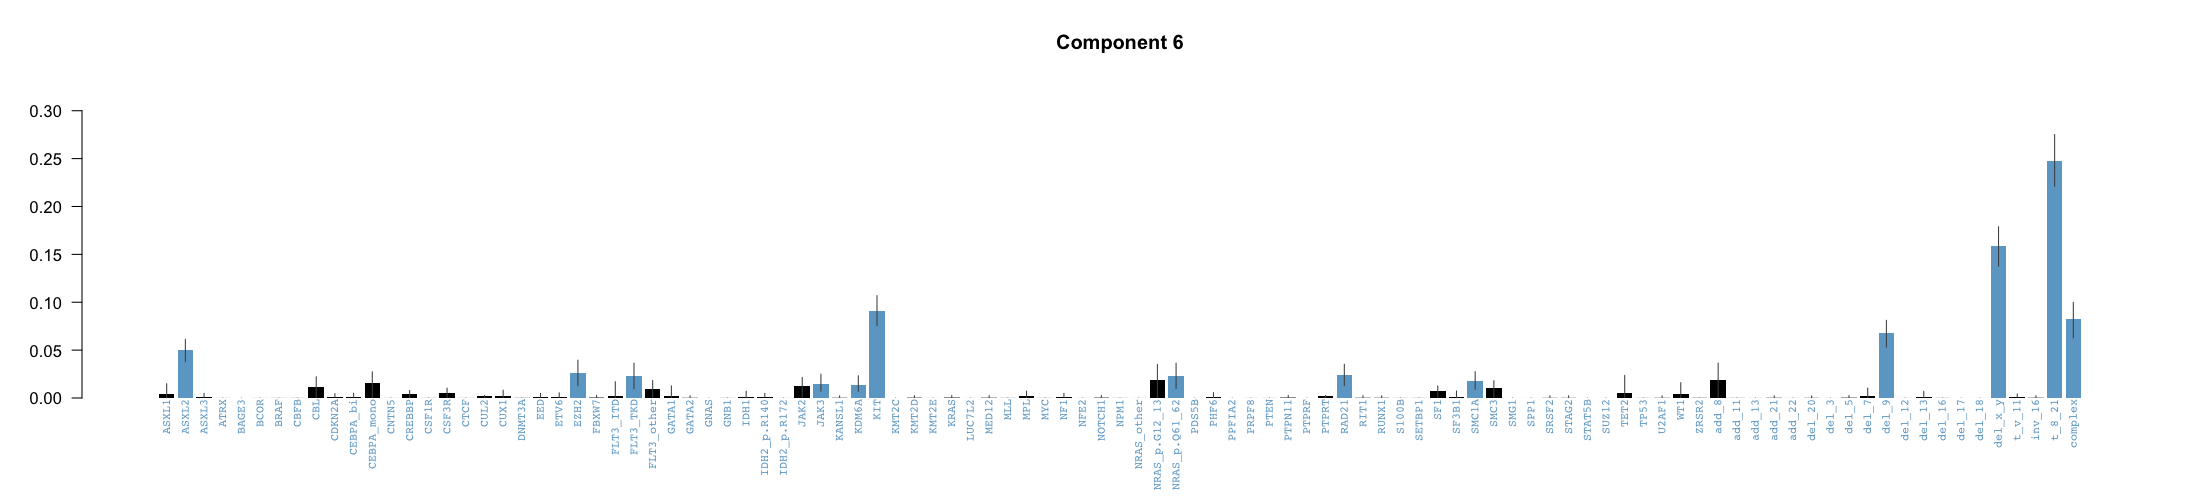

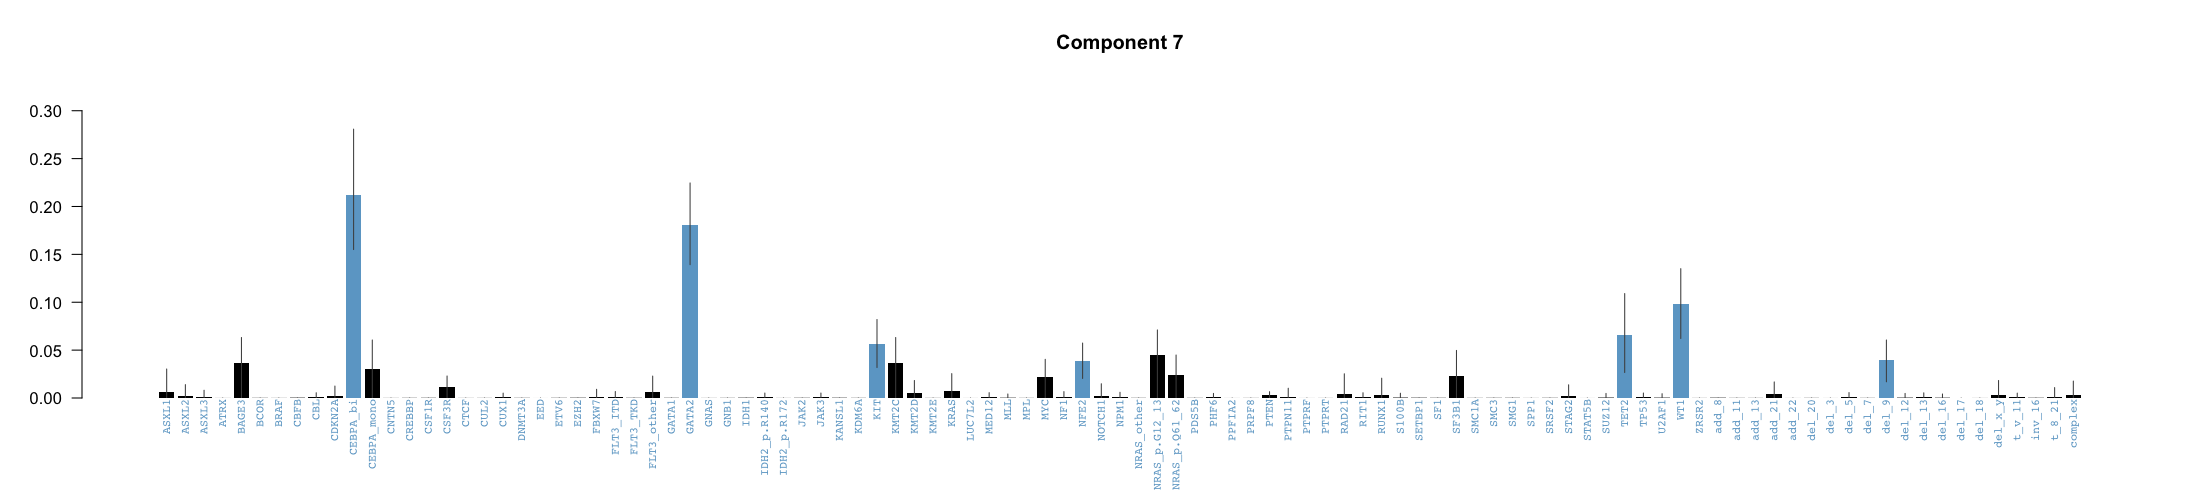

In [17]:
plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))

In [18]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])

Number of components: 7
Number of NA rows   : 65


values      count freq            
2  1            858  39.906976744186 
3  2            325  15.1162790697674
5  4            305  14.1860465116279
4  3            233  10.8372093023256
6  5            152  7.06976744186047
7  6            111  5.16279069767442
9  NaN           65  3.02325581395349
8  7             51  2.37209302325581
1  0             50  2.32558139534884
11 -- total -- 2150  100%

In [ ]:
#3 13 350 7000 0.5 2

In [30]:
number_of_chains <- 3
chain_list <- vector('list', number_of_chains)

for (i in 1:number_of_chains) {
    seed <- i * 100
    print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))
    
    # run single hdp chain
    chain_list[[i]] <- activate_and_run_hdp(hdp,
                                            initcc = 13,
                                            burnin = 7000,
                                            n      = 350,
                                            space  = 20,
                                            seed   = seed)
    print_and_flush('\n')
}

multi_output <- hdp_multi_chain(chain_list)
multi_output

### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"



Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 1050 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of data items per DP: 0 2 2 6 3 6 2 4 3 2 ...
 Index of conparam per DP: 1 1 1 1 1 1 1 1 1 1 ...
 Conparam hyperparameters and current value:
           Shape Rate     Value
Conparam 1   0.5    2 0.4598926
 Number of data categories: 103 
 Number of clusters: 10 
 Initialised with 13 clusters, using random seed 100 

Extract HDP components from posterior sampling
  → extract components... done!
* 7 components found


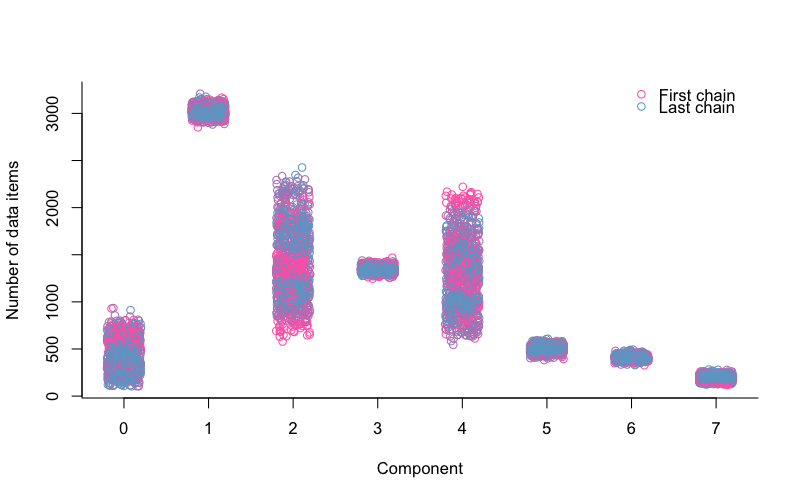

In [34]:
multi_output_cluster_10 <- extract_components(multi_output)
plot_components_size(multi_output_cluster_10)

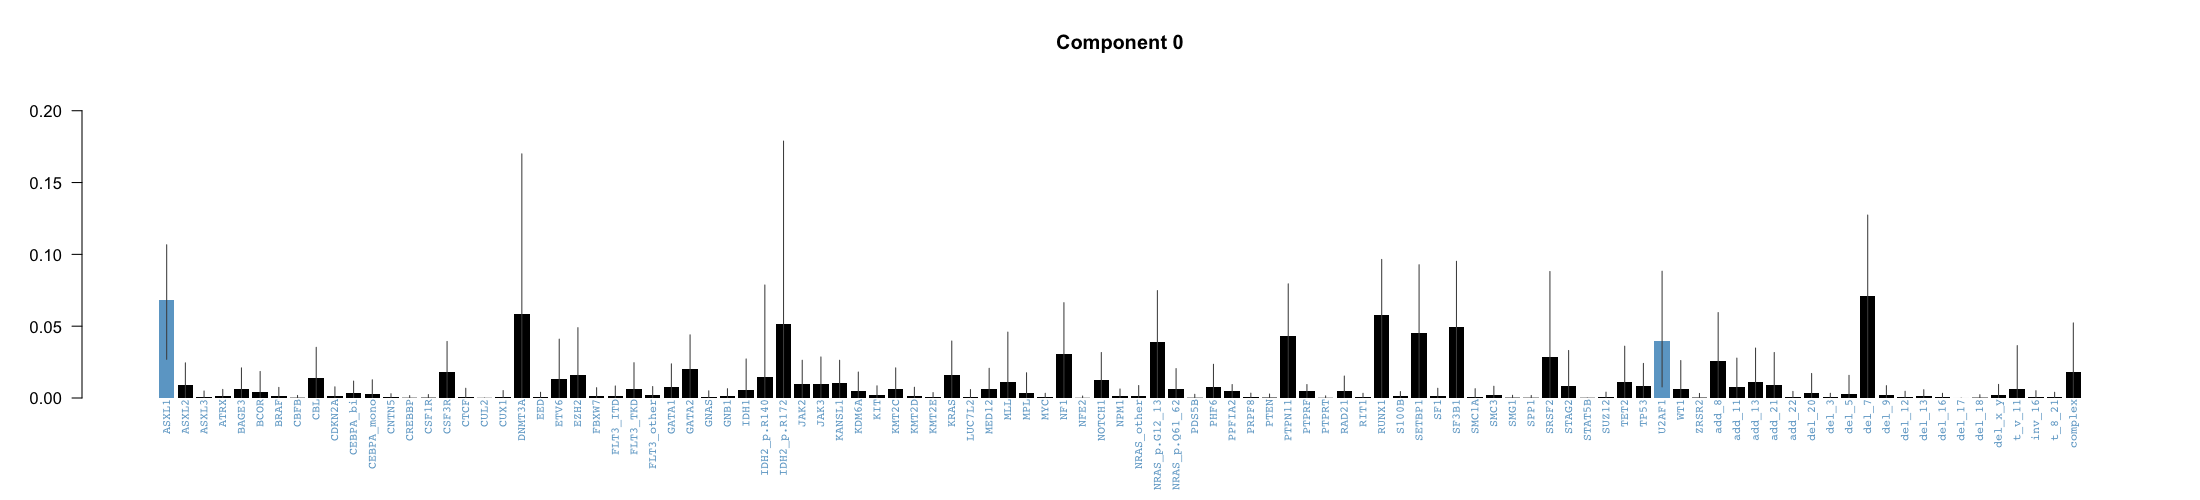

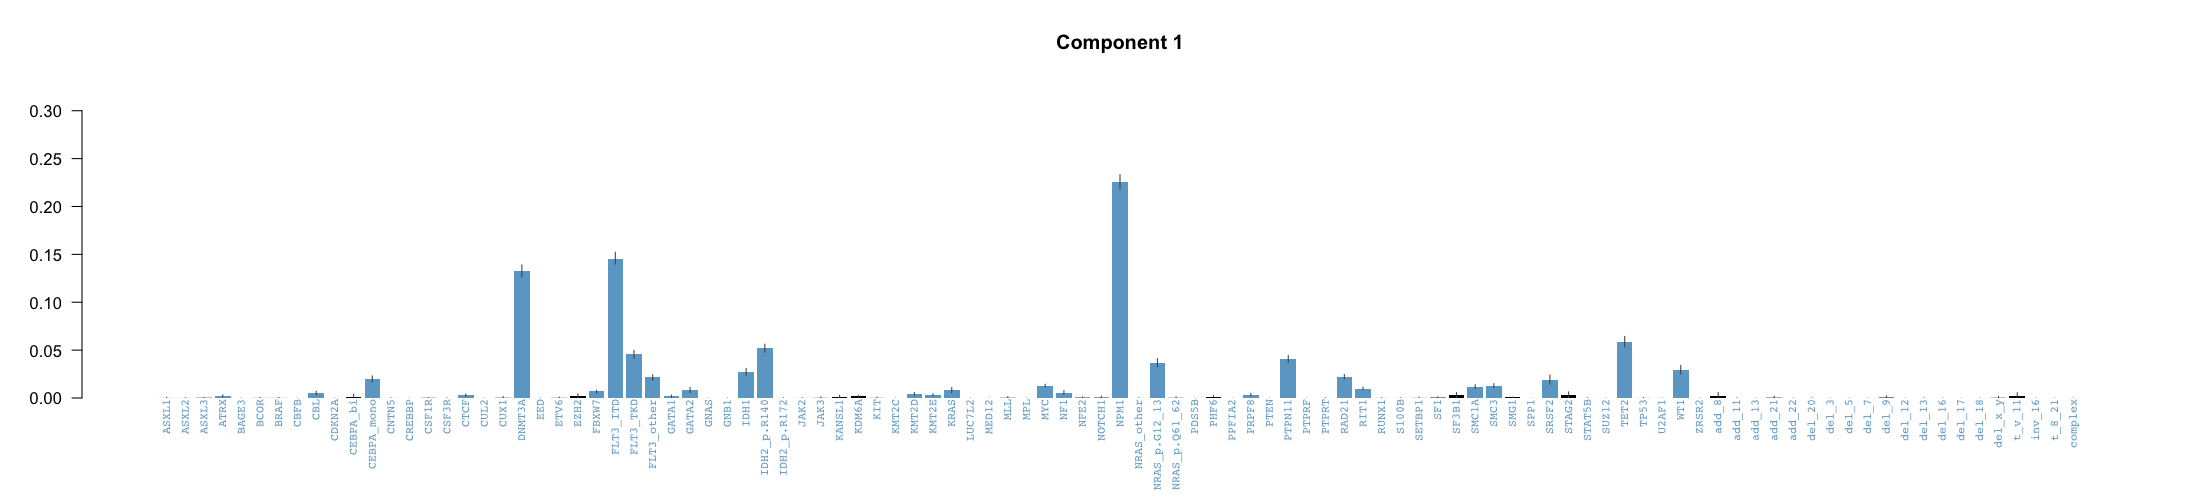

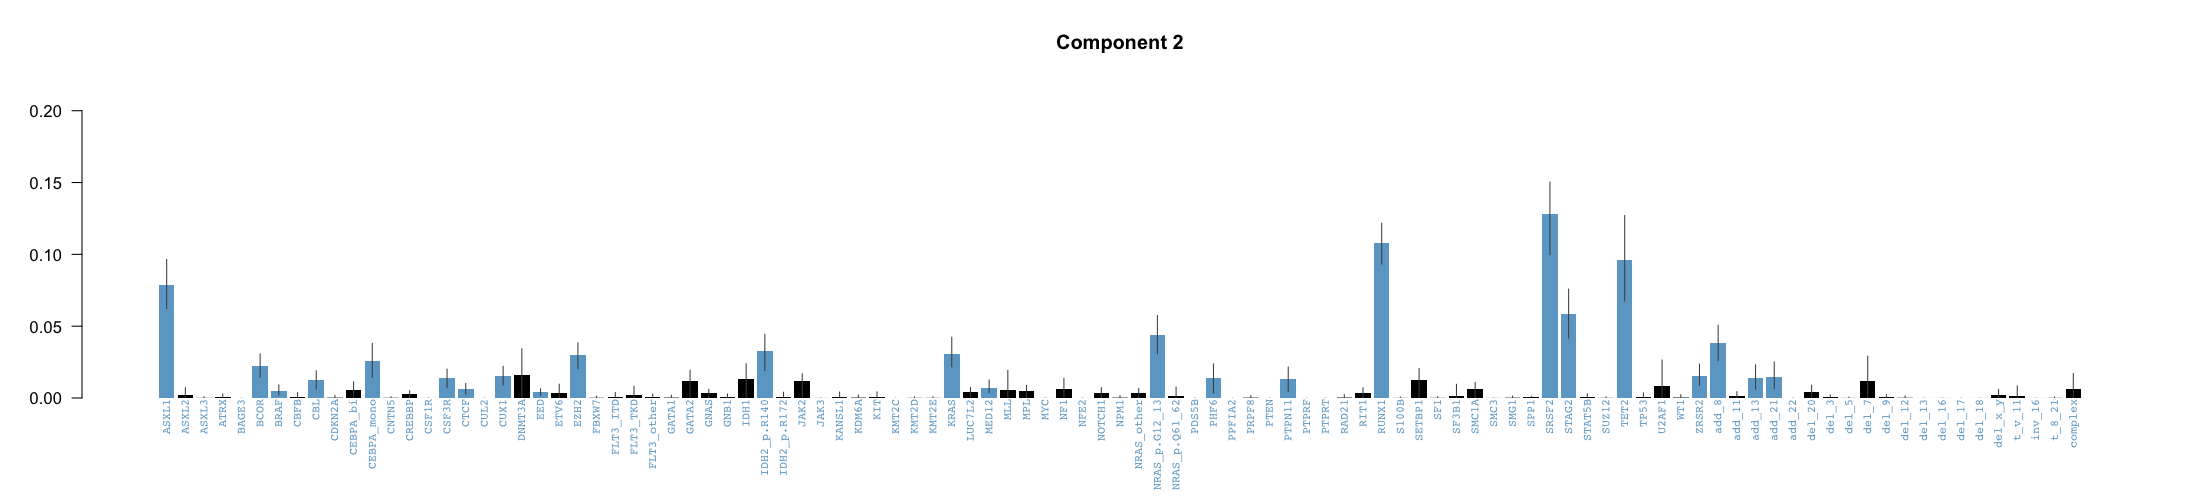

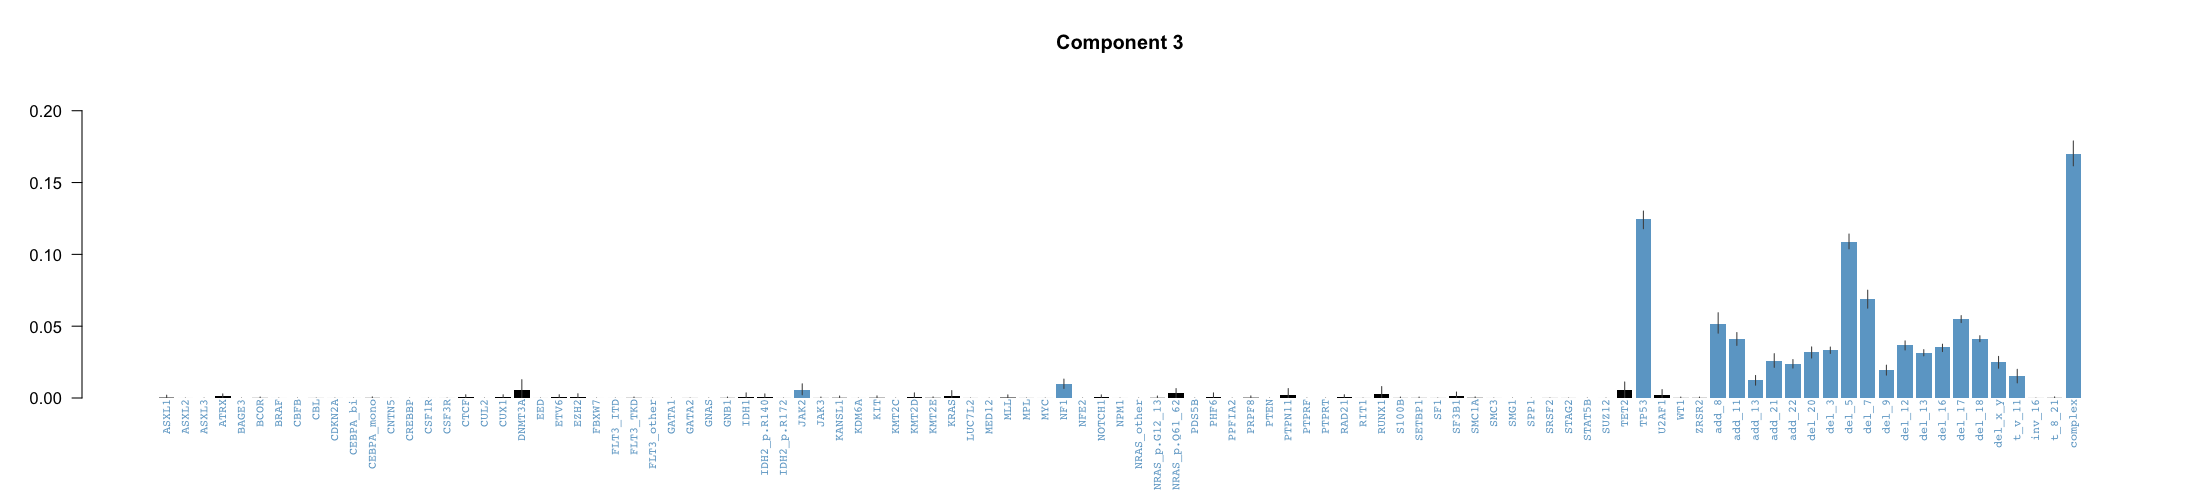

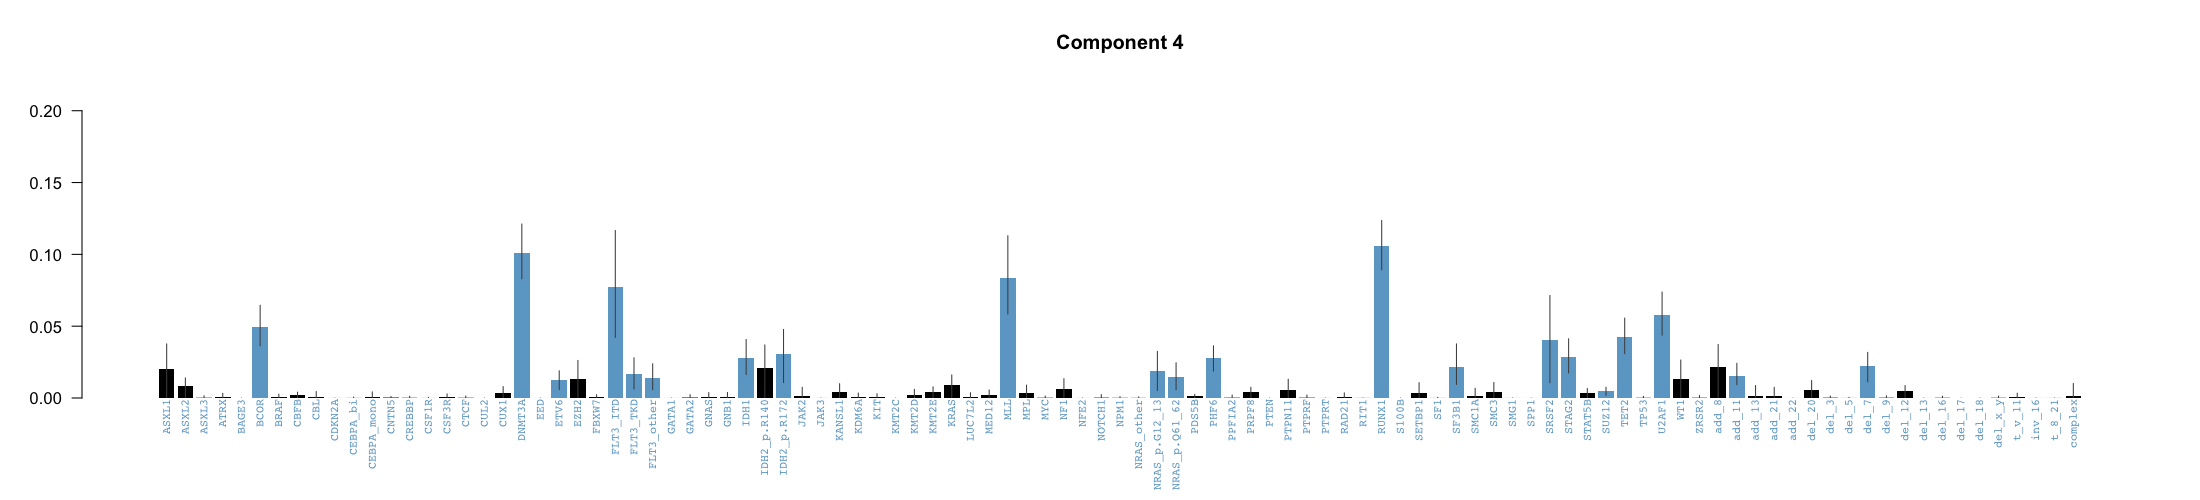

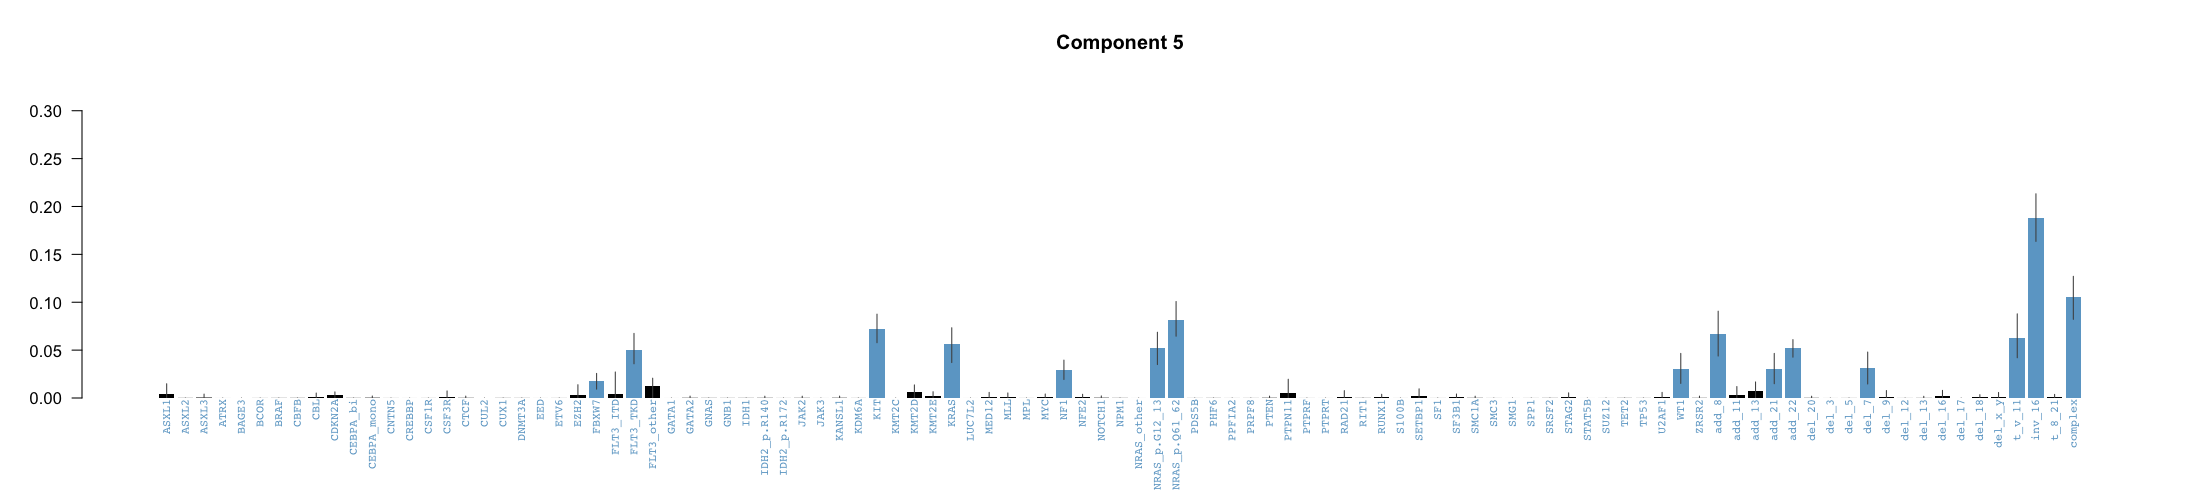

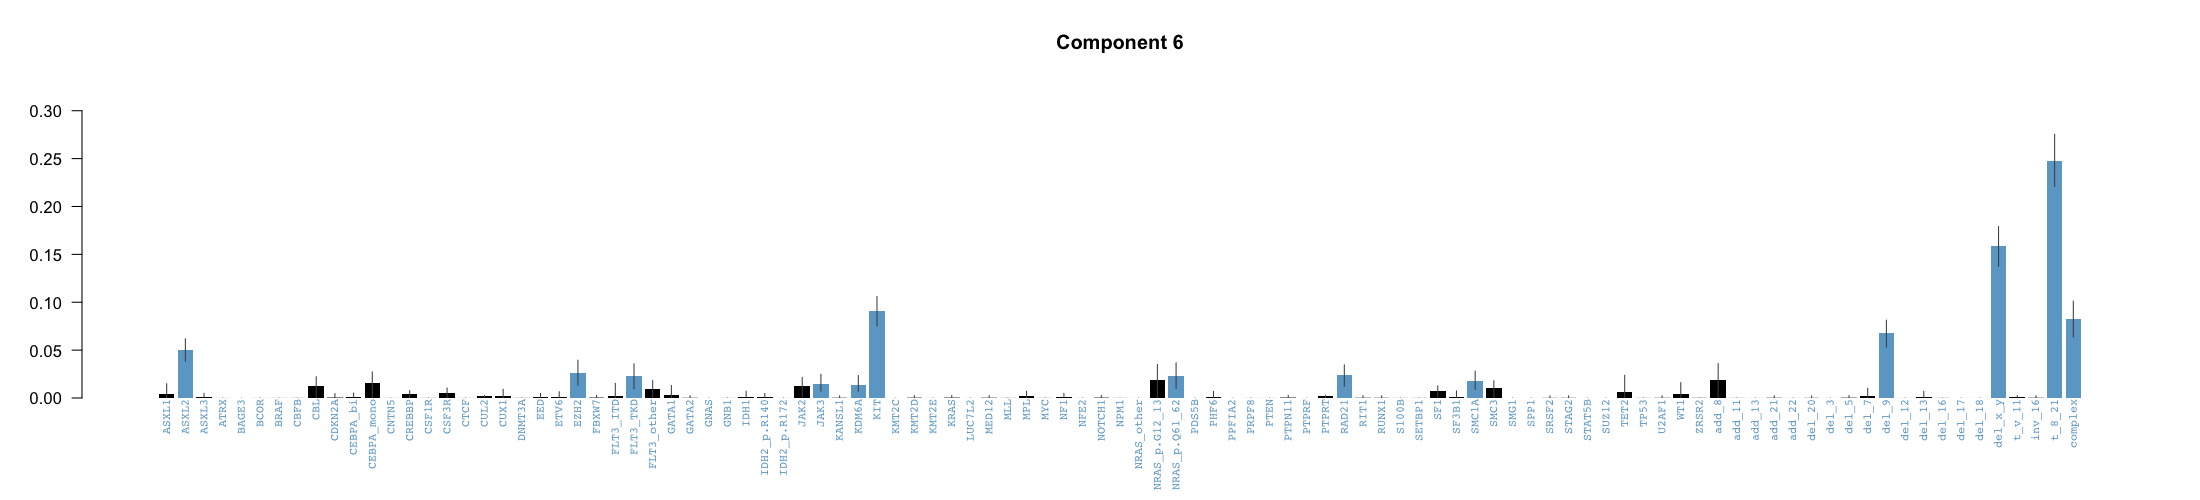

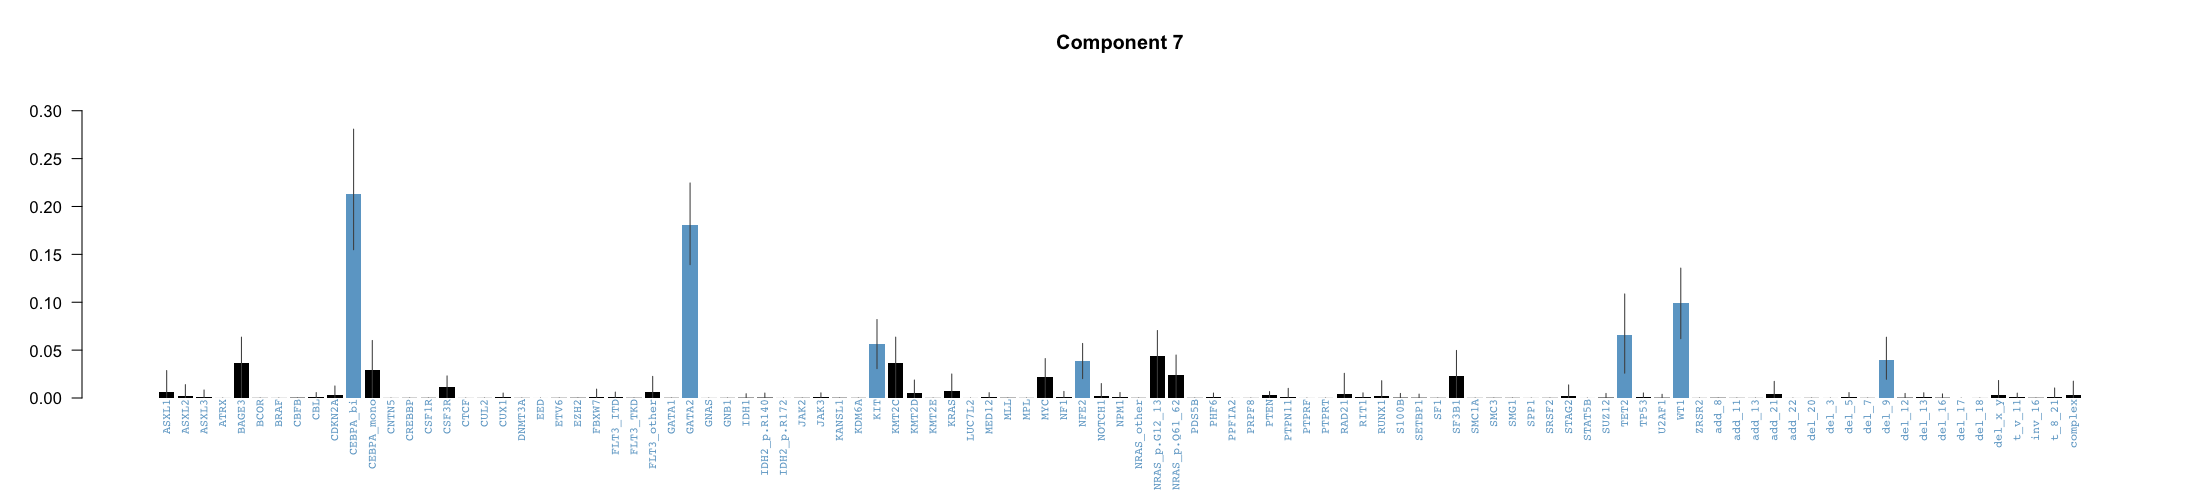

In [35]:
plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))

In [36]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])

Number of components: 7
Number of NA rows   : 65


values      count freq            
2  1            858  39.906976744186 
3  2            316  14.6976744186047
5  4            316  14.6976744186047
4  3            234  10.8837209302326
6  5            152  7.06976744186047
7  6            111  5.16279069767442
9  NaN           65  3.02325581395349
8  7             51  2.37209302325581
1  0             47  2.18604651162791
11 -- total -- 2150  100%

In [ ]:
#3 15 350 7000 0.5 2

In [8]:
number_of_chains <- 3
chain_list <- vector('list', number_of_chains)

for (i in 1:number_of_chains) {
    seed <- i * 100
    print_and_flush(sprintf('### Experiment %d (seed = %d) ###\n', i, seed))
    
    # run single hdp chain
    chain_list[[i]] <- activate_and_run_hdp(hdp,
                                            initcc = 13,
                                            burnin = 7000,
                                            n      = 350,
                                            space  = 20,
                                            seed   = seed)
    print_and_flush('\n')
}

multi_output <- hdp_multi_chain(chain_list)
multi_output

### Experiment 1 (seed = 100) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"

### Experiment 2 (seed = 200) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.4 mins"

### Experiment 3 (seed = 300) ###
Activate HDP nodes and run posterior sampling
  → activate HDP nodes... done!
  → run posterior sampling...
[1] "7000 burn-in iterations in 0.3 mins"



Object of class hdpSampleMulti 
 Number of chains: 3 
 Total posterior samples: 1050 
 Components: NO. Run hdp_extract_components 
 ----------
 Final hdpState from first chain: 
Object of class hdpState 
 Number of DP nodes: 2151 
 Index of parent DP: 0 1 1 1 1 1 1 1 1 1 ...
 Number of data items per DP: 0 2 2 6 3 6 2 4 3 2 ...
 Index of conparam per DP: 1 1 1 1 1 1 1 1 1 1 ...
 Conparam hyperparameters and current value:
           Shape Rate     Value
Conparam 1   0.5    2 0.4598926
 Number of data categories: 103 
 Number of clusters: 10 
 Initialised with 13 clusters, using random seed 100 

Extract HDP components from posterior sampling
  → extract components... done!
* 7 components found


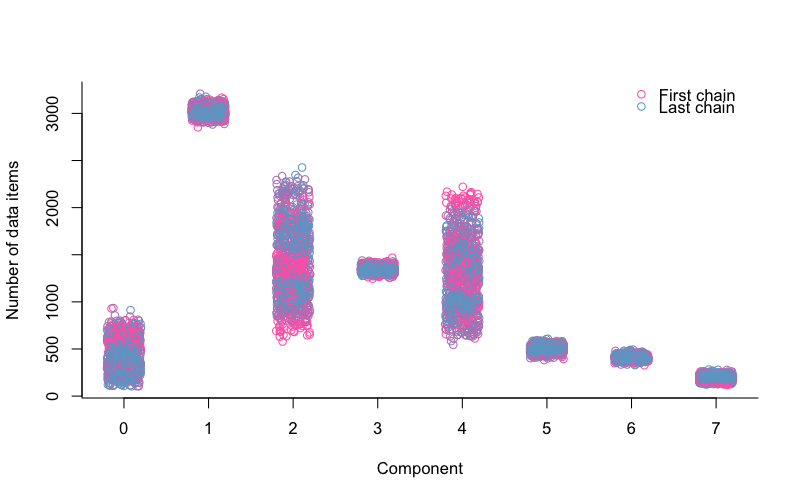

In [9]:
multi_output_cluster_10 <- extract_components(multi_output)
plot_components_size(multi_output_cluster_10)

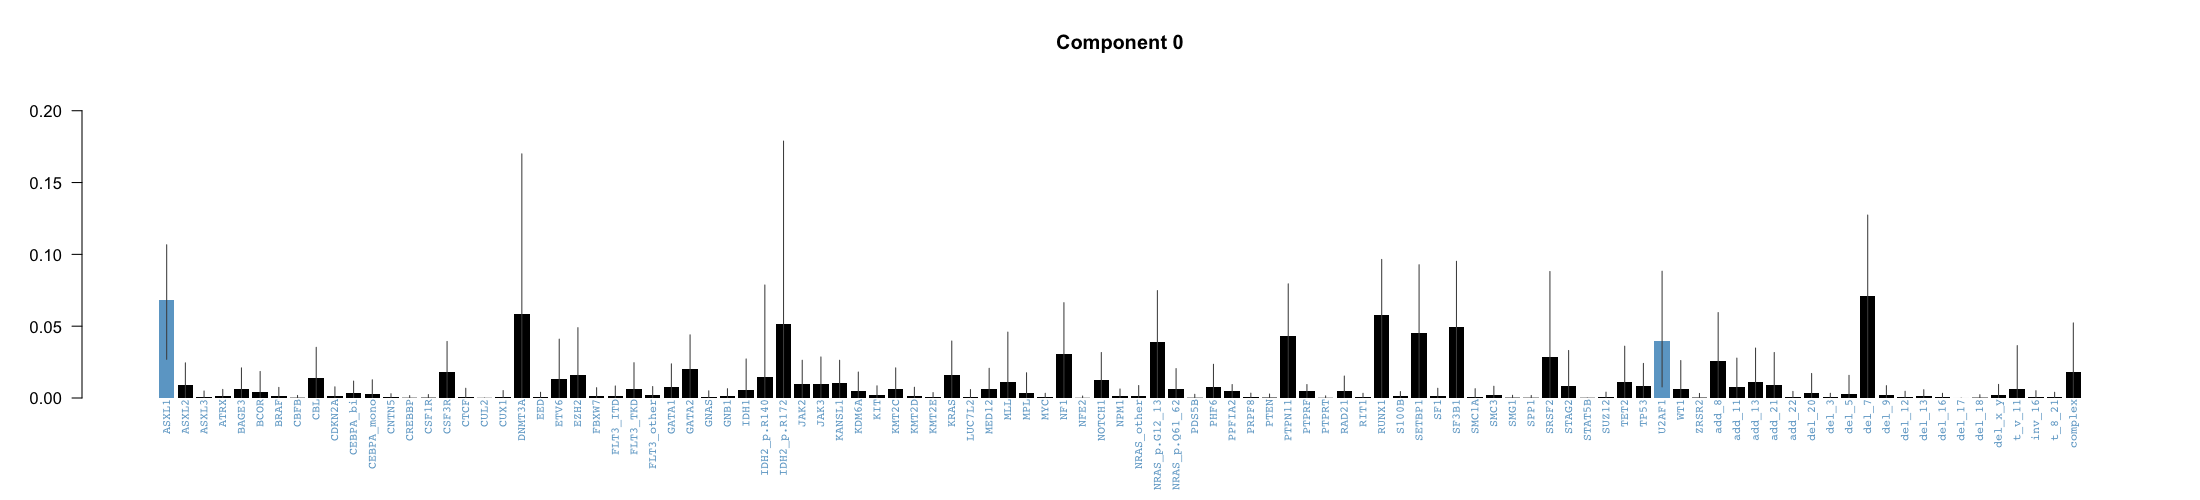

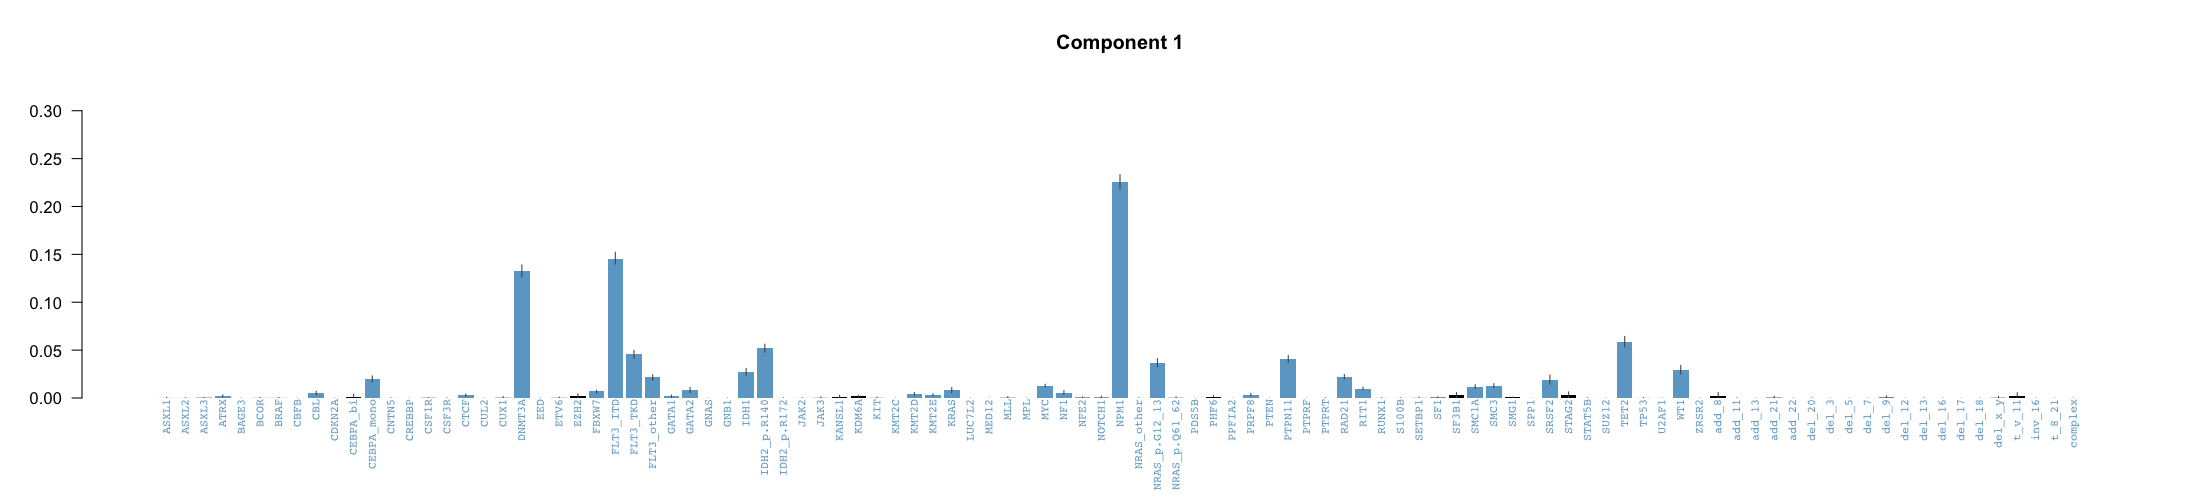

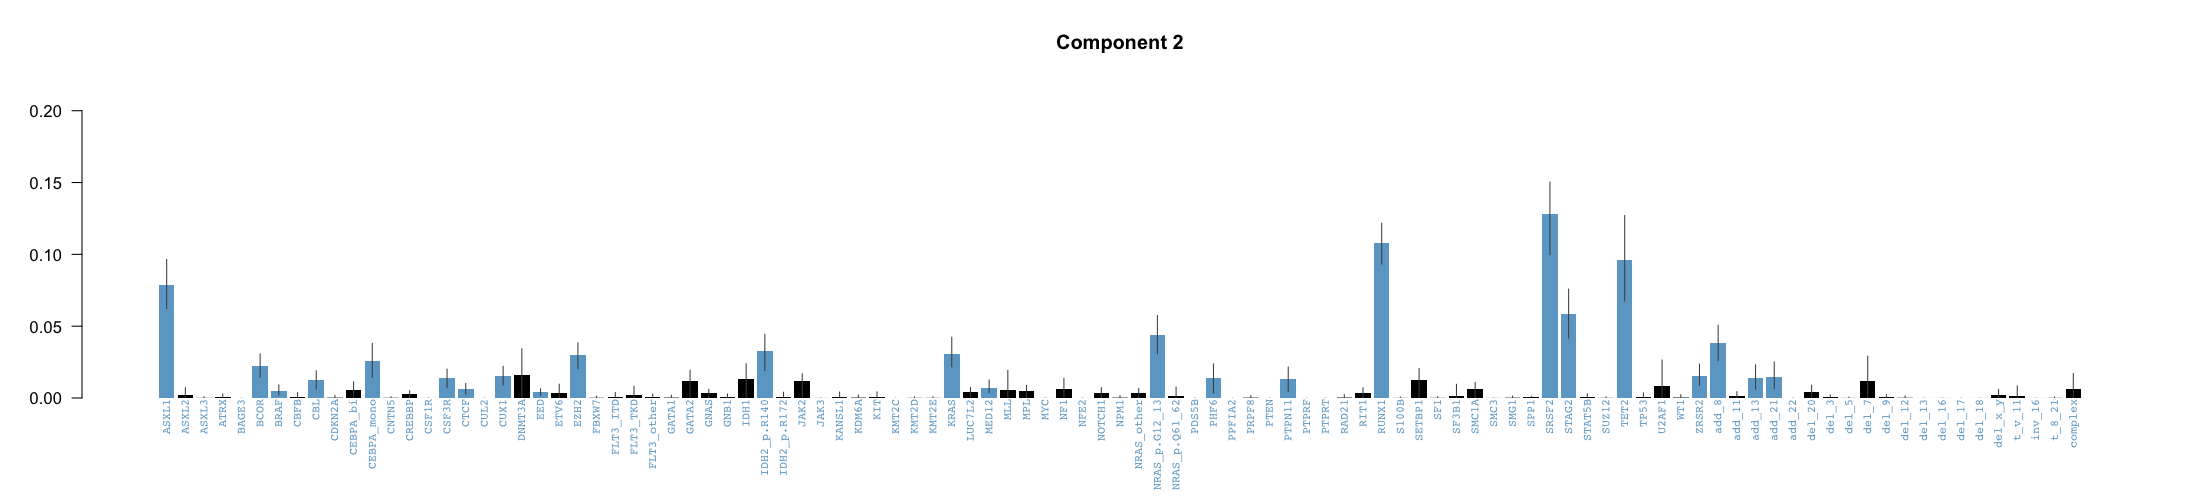

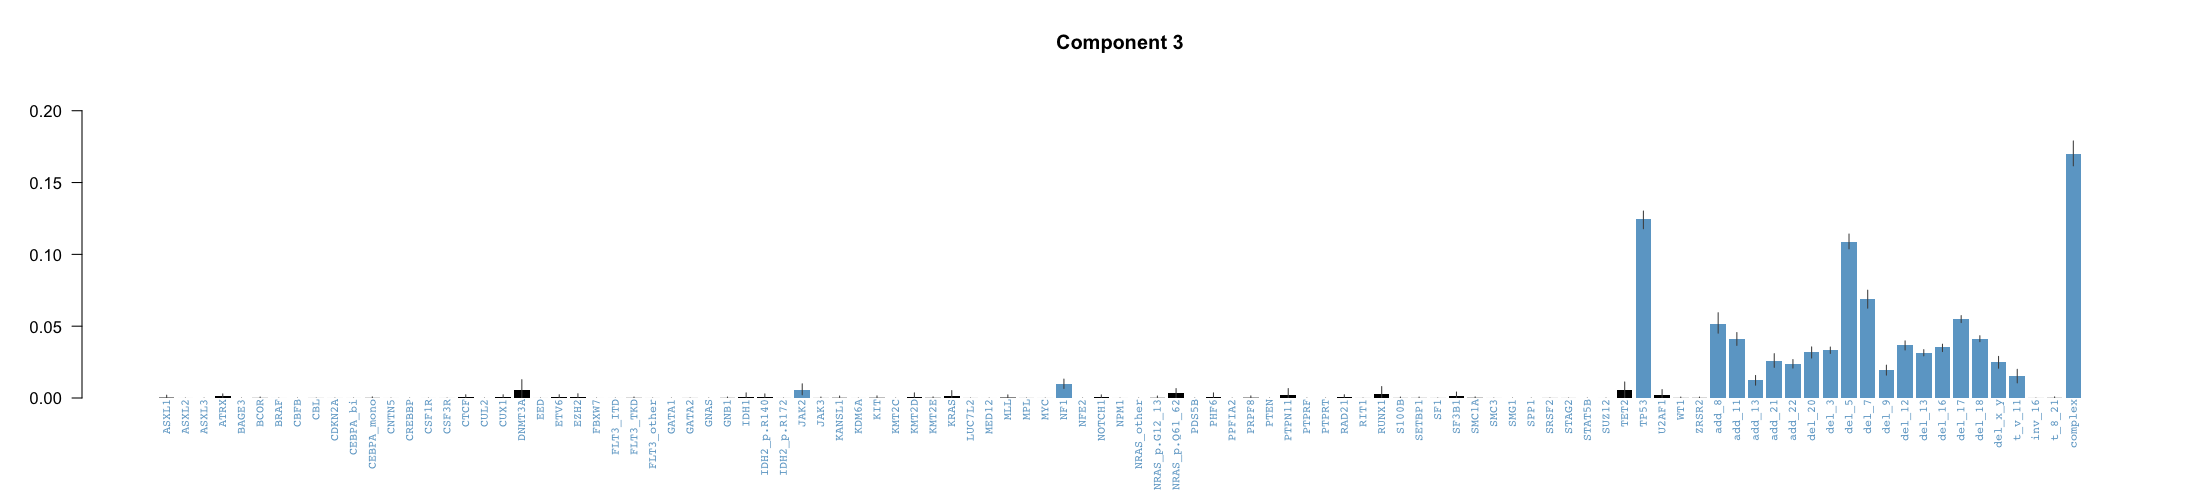

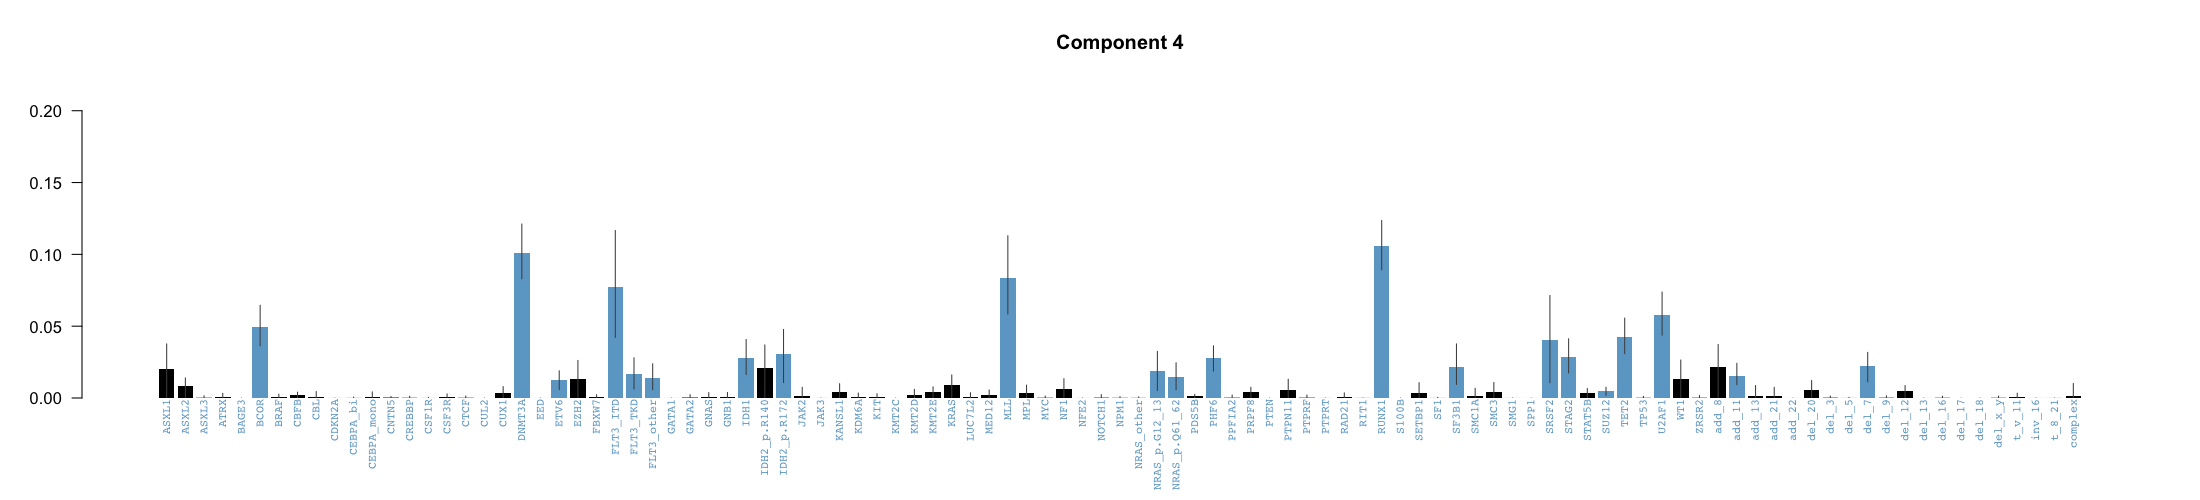

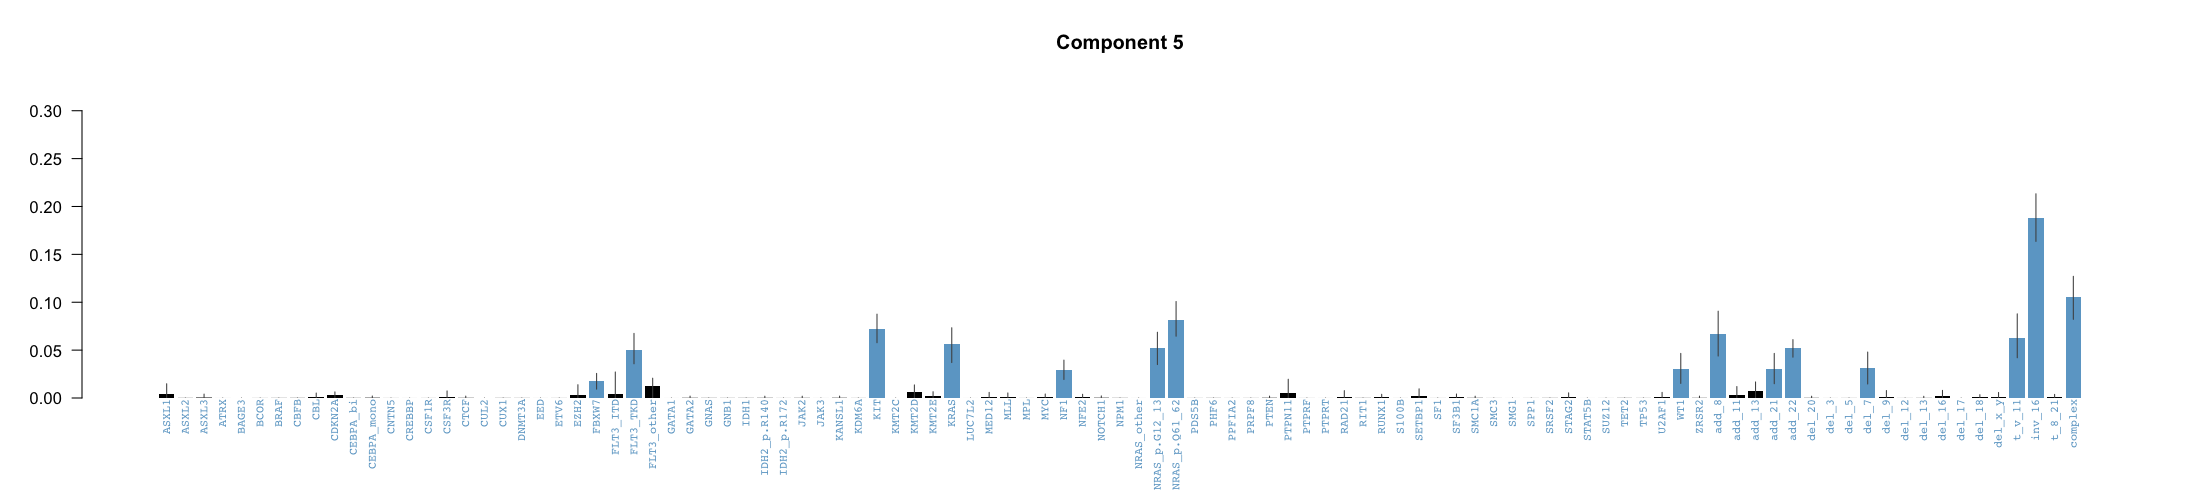

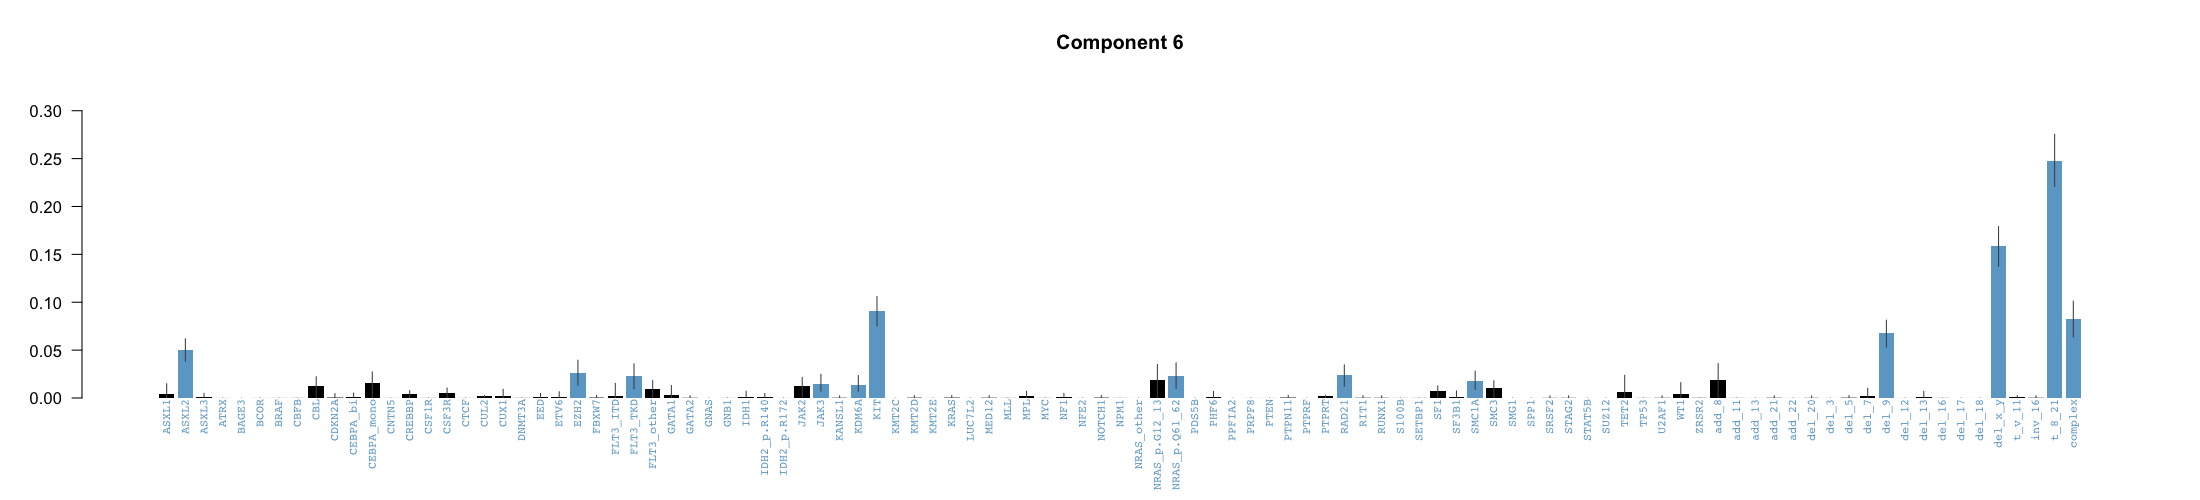

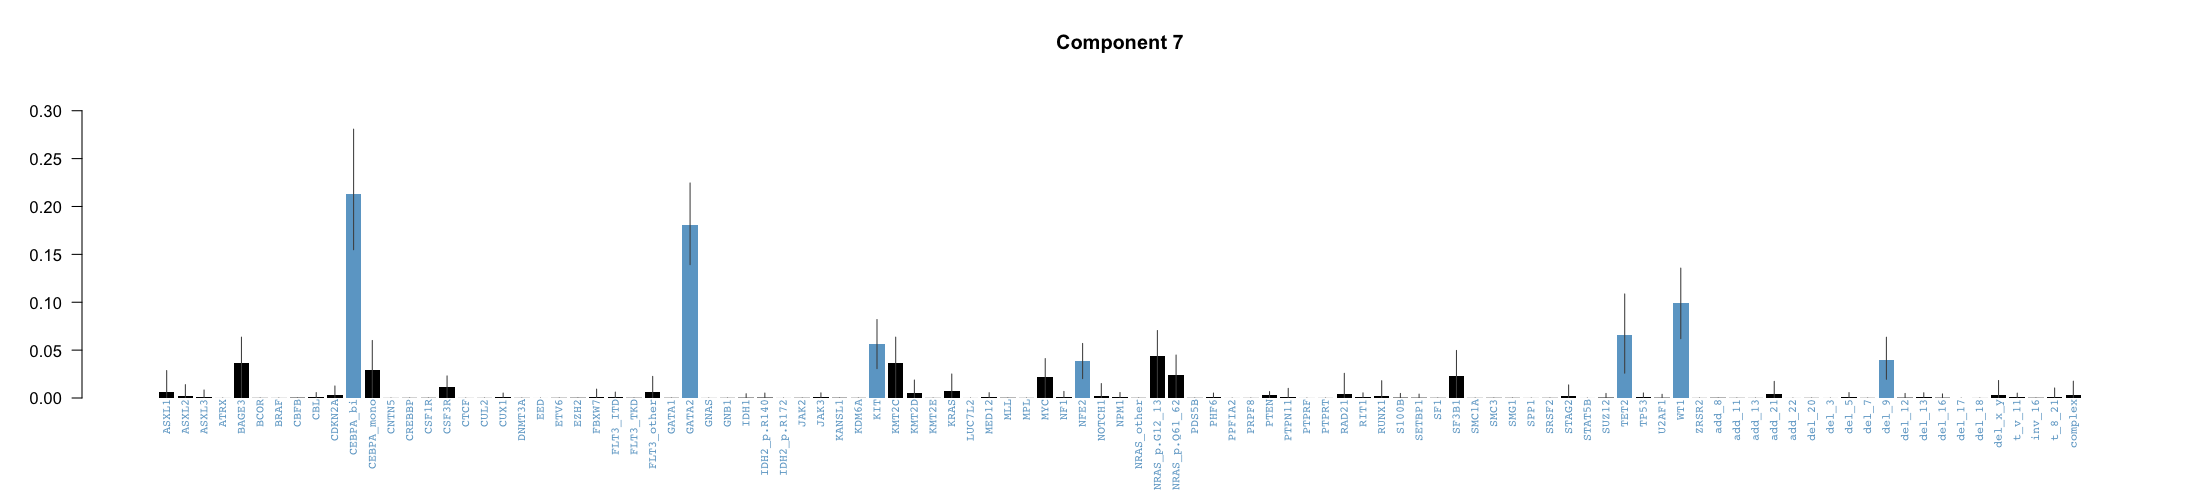

In [10]:
plot_category_distribution_by_component(multi_output_cluster_10, colnames(df_final))

In [11]:
dd_predicted_10_components <- get_prediction_result_dataframe(multi_output_cluster_10, df_final)
get_table(dd_predicted_10_components[,'predicted_component'])

Number of components: 7
Number of NA rows   : 65


values      count freq            
2  1            858  39.906976744186 
3  2            316  14.6976744186047
5  4            316  14.6976744186047
4  3            234  10.8837209302326
6  5            152  7.06976744186047
7  6            111  5.16279069767442
9  NaN           65  3.02325581395349
8  7             51  2.37209302325581
1  0             47  2.18604651162791
11 -- total -- 2150  100%

In [ ]:
#install.packages('tidyverse')
remove.packages("cluster")
#install.packages('cluster')
#install.packages('factoextra')
#install.packages('dendextend')
library(tidyverse)  # data manipulation
#library(cluster)    # clustering algorithms
library(factoextra) # clustering visualization
library(dendextend) # for comparing two dendrograms

In [ ]:
# Dissimilarity matrix
d <- dist(df_final, method = "binary")

# Hierarchical clustering using Complete Linkage
hc1 <- hclust(d, method = "complete" )

# Plot the obtained dendrogram
plot(hc1, cex = 0.6, hang = -1)

In [ ]:
hc5 <- hclust(d, method = "ward.D2" )

In [ ]:
plot(hc5, cex = 0.6)
rect.hclust(hc5, k = 10, border = 2:5)

In [ ]:
sub_grp <- cutree(hc5, k = 10)

In [ ]:
fviz_cluster(list(data = df_final, cluster = sub_grp))